# Imports and general settings

## Imports

In [1]:
from IPython.display import display, HTML

import sys
sys.path.append('..')
sys.path.append('../../')

from util.putil import iinc, idec, iprint, subdir_paths,iset
import os
import pandas as pd
pd.set_option('display.width', 5000)
pd.set_option('max_colwidth', 50)
pd.set_option('max_columns', 50)
pd.set_option('precision', 3)
import re
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as mt
import numpy as np
import ast
import matplotlib.patches as mpatches
import math

## Matplotlib Settings

In [2]:
sns.set(font_scale=3.0, rc={
    "lines.linewidth": 3,
    "lines.markersize":20,
    "ps.useafm": True,
    "axes.facecolor": 'white',
    "font.sans-serif": ["Helvetica"],
    "pdf.use14corefonts" : True,
    "text.usetex": False,
    })
sns.set(style="whitegrid")
LINEWIDTH = 3
MARKERSIZE = 10
TICKLABELSIZE = 14
LEGENDLABELSIZE = 14
LABELSIZE = 23
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 1.0

## Configs

In [3]:
OUTPUT_DIR = "/data/anirudh/output/evaluating_human_rationales"
from emnlp20.config.data_config import dataset_info
from emnlp20.fidelity.fidelity import Fidelity


datasets = [
	'esnli',
	'fever',
	'movies',
	'multirc',
	'personal_attacks',
	'personal_attacks_small',
	'stanford_treebank'
				]

name_to_prefix = {
	'E-SNLI':'esnli',
				  'FEVER':'fever',
				  'Movie reviews':'movies',
				  'MultiRC':'multirc',
				  'Wikipedia personal attacks':'personal_attacks',
    'Wikipedia personal attacks small':'personal_attacks_small',
				  'Stanford treebank':'stanford_treebank',
'movie reviews':'movies',}


dataset_names = ["Wikipedia personal attacks", "Stanford treebank", "movie reviews", "MultiRC", "FEVER", "E-SNLI"]
datasetabs = ["WikiAttack", "SST", "Movie", "MultiRC", "FEVER", "E-SNLI"]
dataset_filenames = ["personal_attacks", "stanford_treebank", "movies", "multirc", "fever", "esnli"]
corr_dataset = {"movies": "movie reviews", "multirc": "MultiRC",
                "personal_attacks": "Wikipedia personal attacks", "stanford_treebank": "Stanford treebank",
               "fever": "FEVER", "esnli": "E-SNLI"}
hatch_list = ["\\", '/', '+']
dataset_ab_dict = {}
for i in range(len(dataset_names)):
    dataset_ab_dict[dataset_names[i]] = datasetabs[i]
dataset_ab_dict["Movie reviews"] = datasetabs[2]

lowercase_to_abs = {}
for i in range(len(datasetabs)):
    lowercase_to_abs[str.lower(datasetabs[i])] = datasetabs[i]
lowercase_to_abs["movies"] = datasetabs[2]
lowercase_to_abs["esnli"] = datasetabs[5]
lowercase_to_abs["wikismall"] = "WikiSmall"


markers = ["^", "*", "<", ">", "o", "v"]
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
dataset_colors = {}
dataset_colors_idx = {}
dataset_markers = {}
acc_labels = {}
for i in range(len(dataset_names)):
    dataset_colors[dataset_names[i]] = colors[i]
    dataset_markers[dataset_names[i]] = markers[i]
    acc_labels[dataset_names[i]] = datasetabs[i]
    dataset_colors_idx[i] = colors[i]

model_corr_label = {"logistic_regression": "Logistic regression",
                   "random_forest": "Random Forest",
                   "lstm": "LSTM",
                   "roberta": "RoBERTa"}

In [4]:
fidelity_calculator = Fidelity()
# fidelity_calculator = Fidelity(experiment_id='fidelity_curve_plotting_2')

# Fig 1 Rationale percentage

In [5]:
full_dataset_stat_df = pd.read_csv('/data/anirudh/output/evaluating_human_rationales/all_stats.csv')
full_dataset_stat_df

,Unnamed: 0,dataset,classes,train_rows,dev_rows,test_rows,type,mean_rationale_length,mean_text_length,mean_rationale_percent,mean_rationale_length_class,mean_rationale_percent_class,mean_text_length_class,mean_text_length_z,mean_text_length_all,mean_text_length_train,mean_text_length_dev,mean_text_length_test,mean_rationale_length_z
0,0,Wikipedia personal attacks,"[0, 1]",69523,23159,23177,RC,6.541,51.807,0.191,"[1.594392523364486, 11.31768953068592]","[0.03524418189895078, 0.34193779674864144]","[58.390654205607476, 45.44945848375451]",51.807,85.914,85.834,85.050,87.017,6.541
1,1,Stanford treebank,"['neg', 'pos']",6920,872,1821,RC,6.453,19.310,0.346,"[6.594086021505376, 6.321579689703809]","[0.3551400744025893, 0.3383788177845331]","[19.15268817204301, 19.45678017328229]",19.310,19.310,19.300,19.548,19.233,6.453
2,2,Movie reviews,"['NEG', 'POS']",1600,200,199,RC,82.420,774.270,0.113,"[95.699, 69.12812812812813]","[0.1355216243329011, 0.0909917252765354]","[731.786, 816.7957957957958]",774.270,774.270,773.289,761.455,795.035,82.420
3,3,MultiRC,"[False, True]",24029,3214,4848,RC,69.805,321.749,0.229,"[68.61352898671558, 71.32503546099291]","[0.2240102525983747, 0.2360626859404243]","[323.8500361291757, 319.06843971631207]",321.749,321.749,323.951,324.203,309.208,69.805
4,4,FEVER,"['REFUTES', 'SUPPORTS']",63818,6122,6111,RC,53.574,320.741,0.240,"[53.951005867560774, 53.40093119503363]","[0.24983310271212125, 0.23594073928729245]","[311.977409891031, 324.7473127550727]",320.741,320.741,330.261,278.266,263.872,53.574
5,5,E-SNLI,"['contradiction', 'entailment', 'neutral']",549309,9823,9807,RC,5.011,21.305,0.252,"[5.223496971007081, 6.531629120676775, 3.26939...","[0.26237412126665827, 0.33789405815877593, 0.1...","[21.25021221403829, 20.526236597607298, 22.142...",21.305,21.305,21.266,22.436,22.390,5.011


In [6]:
plot_data = {"dataset": [], "class": [], "rationale_percentage": []}
datasets = ["Wikipedia personal attacks", "Stanford treebank", "Movie reviews", "MultiRC", "FEVER", "E-SNLI"]
for dataset in datasets:
    tmp_df = full_dataset_stat_df[full_dataset_stat_df["dataset"] == dataset]
    classes = eval(tmp_df["classes"].tolist()[0])
    rationale_percentage = eval(tmp_df["mean_rationale_percent_class"].tolist()[0])
    for idx in range(len(classes)):
        plot_data["dataset"].append(dataset_ab_dict[dataset])
        plot_data["class"].append("class "+str(idx))
        plot_data["rationale_percentage"].append(rationale_percentage[idx]*100)
plot_data_df = pd.DataFrame(plot_data)

In [7]:
plot_data_df

,dataset,class,rationale_percentage
0,WikiAttack,class 0,3.524
1,WikiAttack,class 1,34.194
2,SST,class 0,35.514
3,SST,class 1,33.838
4,Movie,class 0,13.552
5,Movie,class 1,9.099
6,MultiRC,class 0,22.401
7,MultiRC,class 1,23.606
8,FEVER,class 0,24.983
9,FEVER,class 1,23.594


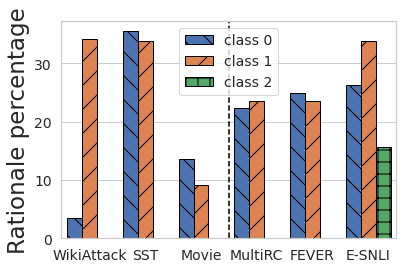

In [10]:
bar = sns.barplot(x="dataset", y="rationale_percentage", hue="class", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Rationale percentage", legend_loc="best", legend_frameon=True,
                 bbox_to_anchor=(1.04,1))
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/rationale_percentage.png", bbox_inches = 'tight', dpi=300)
plt.show()

# Fig 2

## Plotting data

In [138]:
model_names = ["logistic_regression", "random_forest", "lstm", "roberta"]
datasets = ["wikiattack", "sst", "movies", "multirc", "fever", "esnli"]
plot_data = {"dataset": [], "model": [], "accuracy": [], "clipped_sufficiency": [],
            "clipped_comprehensiveness": [], "eraser_sufficiency": [], "eraser_comprehensiveness": [],
            "normalized_comprehensiveness": [], "normalized_sufficiency": []}

for model_name in model_names:
    output_dir = os.path.join(OUTPUT_DIR, model_name)
    for dataset in datasets:
        if model_name == "lstm":
            feature_dir = "/data/sam/mita/output/lstm_retraining/lstm/d=" + str(dataset) + "_hs=200_lr=0.001_nte=10_pp=True"
        else:
            feature_dir = os.path.join(output_dir, dataset)
        feature_df = pd.read_csv(os.path.join(feature_dir, "feature.csv"))
        
        y_hat = feature_df["predicted_classes"].to_numpy()
        y = feature_df["true_classes"].to_numpy()
        prob_y_hat = feature_df["prob_y_hat"].to_numpy()
        prob_y_hat_alpha = feature_df["prob_y_hat_alpha"].to_numpy()
        prob_y_hat_alpha_comp = feature_df["prob_y_hat_alpha_comp"].to_numpy()
        null_difference = feature_df["null_diff"].to_numpy()
        
        clipped_sufficiency = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                             prob_y_hat_alpha=prob_y_hat_alpha,
                                             normalization=False)
        
        clipped_comprehensiveness = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                                    prob_y_hat_alpha=prob_y_hat_alpha_comp,
                                                    fidelity_type="comprehensiveness",
                                                    normalization=False)
        eraser_sufficiency = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                             prob_y_hat_alpha=prob_y_hat_alpha,
                                             normalization=False, clip=False)
        
        eraser_comprehensiveness = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                                    prob_y_hat_alpha=prob_y_hat_alpha_comp,
                                                    fidelity_type="comprehensiveness",
                                                    normalization=False, clip=False)


        normalized_sufficiency = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                             prob_y_hat_alpha=prob_y_hat_alpha,
                                             normalization=True, null_difference=null_difference)

        normalized_comprehensiveness = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                                    prob_y_hat_alpha=prob_y_hat_alpha_comp,
                                                    fidelity_type="comprehensiveness",
                                                    normalization=True, null_difference=null_difference)
        
        plot_data["dataset"].append(lowercase_to_abs[dataset])
#         print(dataset)
#         print(lowercase_to_abs[dataset])
#         plot_data["dataset"].append(dataset)
        plot_data["model"].append(model_corr_label[model_name])
        plot_data["accuracy"].append(mt.accuracy_score(y, y_hat))
        
        plot_data["clipped_sufficiency"].append(clipped_sufficiency)
        plot_data["clipped_comprehensiveness"].append(clipped_comprehensiveness)
        plot_data["eraser_sufficiency"].append(eraser_sufficiency)
        plot_data["eraser_comprehensiveness"].append(eraser_comprehensiveness)
        plot_data["normalized_sufficiency"].append(normalized_sufficiency)
        plot_data["normalized_comprehensiveness"].append(normalized_comprehensiveness)
plot_data_df = pd.DataFrame(plot_data)

In [139]:
plot_data_df

,dataset,model,accuracy,clipped_sufficiency,clipped_comprehensiveness,eraser_sufficiency,eraser_comprehensiveness,normalized_comprehensiveness,normalized_sufficiency
0,WikiAttack,Logistic regression,0.713,0.908,0.136,0.938,0.110,0.176,0.179
1,SST,Logistic regression,0.800,0.910,0.136,0.922,0.127,0.581,0.581
2,Movie,Logistic regression,0.784,0.927,0.030,0.937,0.025,0.313,0.192
3,MultiRC,Logistic regression,0.572,0.997,0.002,0.997,0.002,0.050,0.002
4,FEVER,Logistic regression,0.500,0.940,0.020,0.956,0.006,0.210,0.129
5,E-SNLI,Logistic regression,0.535,0.881,0.082,0.894,0.072,0.335,0.297
6,WikiAttack,Random Forest,0.672,0.945,0.113,1.033,0.074,0.154,0.178
7,SST,Random Forest,0.728,0.922,0.097,0.957,0.071,0.345,0.454
8,Movie,Random Forest,0.673,0.887,0.043,0.933,0.026,0.053,0.165
9,MultiRC,Random Forest,0.514,0.777,0.153,0.808,0.078,0.366,0.119


## Accuracy

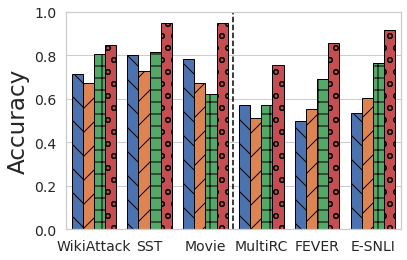

In [140]:
bar = sns.barplot(x="dataset", y="accuracy", hue="model", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Accuracy", legend_loc="upper left", legend_frameon=True,
                 bbox_to_anchor=(1.04,1), add_legend=False)
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/overall/accuracy.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Clipped Sufficiency

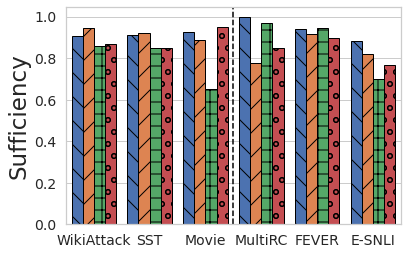

In [141]:
bar = sns.barplot(x="dataset", y="clipped_sufficiency", hue="model", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Sufficiency", legend_loc="upper left", legend_frameon=True,
                 bbox_to_anchor=(1.04,1), add_legend=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/overall/sufficiency.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Clipped Comprehensiveness

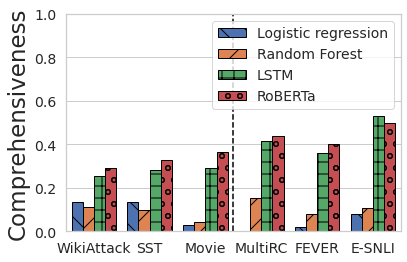

In [142]:
bar = sns.barplot(x="dataset", y="clipped_comprehensiveness", hue="model", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Comprehensiveness", legend_loc="best", legend_frameon=True,
                 bbox_to_anchor=(1.04,1))
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/overall/comprehensiveness.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Eraser Sufficiency

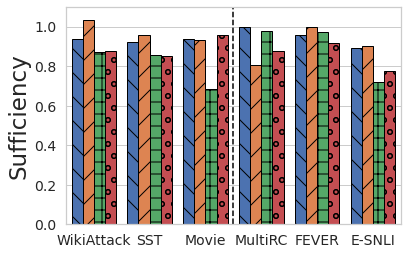

In [143]:
bar = sns.barplot(x="dataset", y="eraser_sufficiency", hue="model", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Sufficiency", legend_loc="best", legend_frameon=True,
                 bbox_to_anchor=(1.04,1), add_legend=False)
plt.ylim(0, 1.1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/overall/eraser_sufficiency.png",
            bbox_inches = 'tight', dpi=300)
plt.show()

## Eraser Comprehensiveness

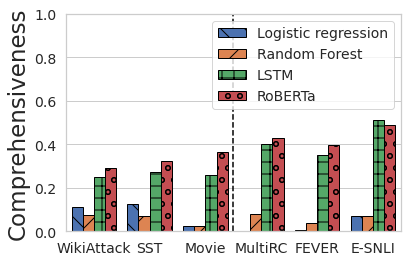

In [145]:
bar = sns.barplot(x="dataset", y="eraser_comprehensiveness", hue="model", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Comprehensiveness", legend_loc="best", legend_frameon=True,
                 bbox_to_anchor=(1.04,1))
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/overall/eraser_comprehensiveness.png",
            bbox_inches = 'tight', dpi=300)
plt.show()

## Normalized Sufficiency

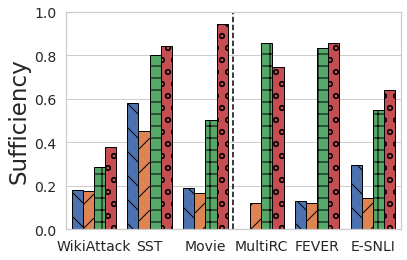

In [147]:
bar = sns.barplot(x="dataset", y="normalized_sufficiency", hue="model", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Sufficiency", legend_loc="best", legend_frameon=True,
                 bbox_to_anchor=(1.04,1), add_legend=False)
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/overall/normalized_sufficiency.png",
            bbox_inches = 'tight', dpi=300)
plt.show()

## Normalized Comprehensiveness

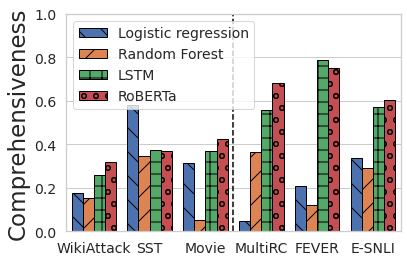

In [148]:
bar = sns.barplot(x="dataset", y="normalized_comprehensiveness", hue="model", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Comprehensiveness", legend_loc="best", legend_frameon=True,
                 bbox_to_anchor=(1.04,1))
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/overall/normalized_comprehensiveness.png",
            bbox_inches = 'tight', dpi=300)
plt.show()

# Fig 3 Class-wise fidelity and accuracy

## Plotting Data

In [19]:
datasets = ["wikiattack", "sst", "movies", "multirc", "fever", "esnli"]
plot_data = {"dataset": [], "class": [], "accuracy": [], "clipped_sufficiency": [],
            "clipped_comprehensiveness": [], "null_difference": [],
            "normalized_sufficiency": [], "normalized_comprehensiveness": []}
model_name = "roberta"
output_dir = os.path.join(OUTPUT_DIR, model_name)
for dataset in datasets:
    feature_dir = os.path.join(output_dir, dataset)
    feature_df = pd.read_csv(os.path.join(feature_dir, "feature.csv"))

    for class_id in [0, 1, 2]:
        feature_class_df = feature_df[feature_df["true_classes"] == class_id]
        y_hat = feature_class_df["predicted_classes"].to_numpy()
        y = feature_class_df["true_classes"].to_numpy()
        prob_y_hat = feature_class_df["prob_y_hat"].to_numpy()
        prob_y_hat_alpha = feature_class_df["prob_y_hat_alpha"].to_numpy()
        prob_y_hat_alpha_comp = feature_class_df["prob_y_hat_alpha_comp"].to_numpy()
        null_difference = feature_class_df["null_diff"].to_numpy()

        clipped_sufficiency = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                             prob_y_hat_alpha=prob_y_hat_alpha,
                                             normalization=False)

        clipped_comprehensiveness = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                                    prob_y_hat_alpha=prob_y_hat_alpha_comp,
                                                    fidelity_type="comprehensiveness",
                                                    normalization=False)
        
        normalized_sufficiency = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                     prob_y_hat_alpha=prob_y_hat_alpha,
                                     null_difference=null_difference,
                                     normalization=True)

        normalized_comprehensiveness = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                                    prob_y_hat_alpha=prob_y_hat_alpha_comp,
                                                    fidelity_type="comprehensiveness",
                                                    null_difference=null_difference,
                                                    normalization=True)

        plot_data["dataset"].append(lowercase_to_abs[dataset])
        plot_data["accuracy"].append(mt.accuracy_score(y, y_hat))
        plot_data["clipped_sufficiency"].append(clipped_sufficiency)
        plot_data["class"].append("class "+str(class_id))
        plot_data["clipped_comprehensiveness"].append(clipped_comprehensiveness)
        plot_data["null_difference"].append(np.mean(null_difference))
        plot_data["normalized_sufficiency"].append(normalized_sufficiency)
        plot_data["normalized_comprehensiveness"].append(normalized_comprehensiveness)
plot_data_df = pd.DataFrame(plot_data)

/data/anaconda3/envs/anirudh/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/anaconda3/envs/anirudh/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/anaconda3/envs/anirudh/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/data/anaconda3/envs/anirudh/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/anaconda3/envs/anirudh/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/anaconda3/envs/anirudh/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a

In [20]:
plot_data_df

,dataset,class,accuracy,clipped_sufficiency,clipped_comprehensiveness,null_difference,normalized_sufficiency,normalized_comprehensiveness
0,WikiAttack,class 0,0.886,0.902,0.047,0.117,0.068,0.055
1,WikiAttack,class 1,0.812,0.833,0.527,0.740,0.669,0.567
2,WikiAttack,class 2,NaN,NaN,NaN,NaN,NaN,NaN
3,SST,class 0,0.934,0.849,0.346,0.552,0.843,0.395
4,SST,class 1,0.967,0.846,0.306,0.435,0.839,0.347
5,SST,class 2,NaN,NaN,NaN,NaN,NaN,NaN
6,Movie,class 0,0.930,0.932,0.499,0.494,0.920,0.557
7,Movie,class 1,0.970,0.970,0.231,0.448,0.966,0.292
8,Movie,class 2,NaN,NaN,NaN,NaN,NaN,NaN
9,MultiRC,class 0,0.760,0.847,0.512,0.388,0.731,0.780


## Accuracy

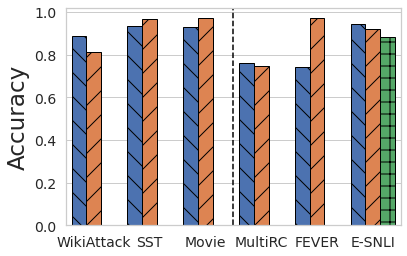

In [21]:
bar = sns.barplot(x="dataset", y="accuracy", hue="class", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Accuracy", legend_loc="upper left", legend_frameon=True,
                 bbox_to_anchor=(1.04,1), add_legend=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/class_wise/accuracy.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Clipped Sufficiency

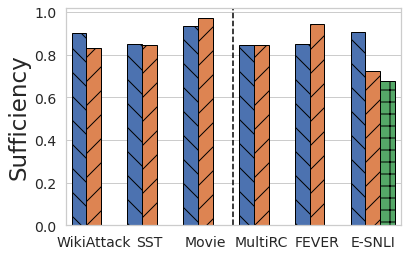

In [22]:
bar = sns.barplot(x="dataset", y="clipped_sufficiency", hue="class", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Sufficiency", legend_loc="upper left", legend_frameon=True,
                 bbox_to_anchor=(1.04,1), add_legend=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/class_wise/clipped_sufficiency.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Clipped Comprehensiveness

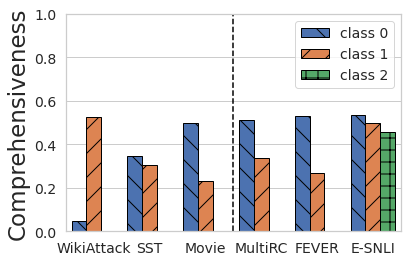

In [23]:
bar = sns.barplot(x="dataset", y="clipped_comprehensiveness", hue="class", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Comprehensiveness", legend_loc="best", legend_frameon=True,
                 bbox_to_anchor=(1.04,1))
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/class_wise/clipped_comprehensiveness.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Appendix plots

### non-normalized fidelity

In [56]:
appendix_plot_data_df = {"dataset": [], "clipped_fidelity": [], "normalized_fidelity": [],
                        "fidelity_type": []}
for dataset in datasetabs:
    tmp_df = plot_data_df[plot_data_df["dataset"]==dataset]
    clipped_sufficiency = np.array([])
    normalized_sufficiency = np.array([])
    clipped_comprehensiveness = np.array([])
    normalized_comprehensiveness = np.array([])
    if dataset == "E-SNLI":
        classes = ["class 0", "class 1", "class 2"]
    else:
        classes = ["class 0", "class 1"]
    for class_id in classes:
        plt_tmp_df = tmp_df[tmp_df["class"] == class_id]
        
        clipped_sufficiency = np.concatenate((clipped_sufficiency,
                                             plt_tmp_df["clipped_sufficiency"].to_numpy()), axis=0)
        normalized_sufficiency = np.concatenate((normalized_sufficiency, 
                                                plt_tmp_df["normalized_sufficiency"].to_numpy()), axis=0)
        clipped_comprehensiveness = np.concatenate((clipped_comprehensiveness,
                                                   plt_tmp_df["clipped_comprehensiveness"].to_numpy()), axis=0)
        normalized_comprehensiveness = np.concatenate((normalized_comprehensiveness, 
                                                plt_tmp_df["normalized_comprehensiveness"].to_numpy()), axis=0)
    appendix_plot_data_df["dataset"].append(dataset)
    appendix_plot_data_df["clipped_fidelity"].append(np.mean(clipped_sufficiency))
    appendix_plot_data_df["normalized_fidelity"].append(np.mean(normalized_sufficiency))
    appendix_plot_data_df["fidelity_type"].append("sufficiency")

    appendix_plot_data_df["dataset"].append(dataset)
    appendix_plot_data_df["clipped_fidelity"].append(np.mean(clipped_comprehensiveness))
    appendix_plot_data_df["normalized_fidelity"].append(np.mean(normalized_comprehensiveness))
    appendix_plot_data_df["fidelity_type"].append("comprehensiveness")
        
appendix_plot_data_df = pd.DataFrame(appendix_plot_data_df)

In [57]:
appendix_plot_data_df

,dataset,clipped_fidelity,normalized_fidelity,fidelity_type
0,WikiAttack,0.867,0.368,sufficiency
1,WikiAttack,0.287,0.311,comprehensiveness
2,SST,0.847,0.841,sufficiency
3,SST,0.326,0.371,comprehensiveness
4,Movie,0.951,0.943,sufficiency
5,Movie,0.365,0.424,comprehensiveness
6,MultiRC,0.847,0.751,sufficiency
7,MultiRC,0.423,0.667,comprehensiveness
8,FEVER,0.896,0.856,sufficiency
9,FEVER,0.399,0.751,comprehensiveness


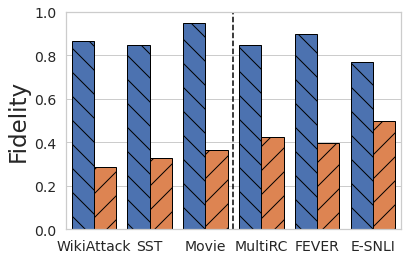

In [58]:
bar = sns.barplot(x="dataset", y="clipped_fidelity", hue="fidelity_type", data=appendix_plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Fidelity", legend_loc="best", legend_frameon=True,
                 bbox_to_anchor=(1.04,1), add_legend=False)
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/class_wise/clipped_fidelity.png", bbox_inches = 'tight', dpi=300)
plt.show()

### Normalized fidelity

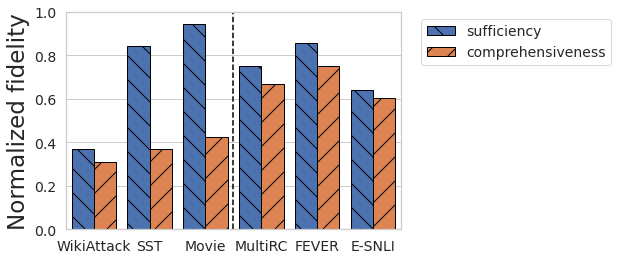

In [61]:
bar = sns.barplot(x="dataset", y="normalized_fidelity", hue="fidelity_type", data=appendix_plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Normalized fidelity", legend_loc="upper left", legend_frameon=True,
                 bbox_to_anchor=(1.04,1))
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/class_wise/normalized_fidelity.png", bbox_inches = 'tight', dpi=300)
plt.show()

# Fig 4

## Null Difference

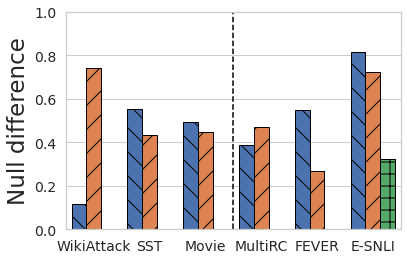

In [22]:
bar = sns.barplot(x="dataset", y="null_difference", hue="class", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Null difference", legend_loc="upper left", legend_frameon=True,
                 bbox_to_anchor=(1.04,1), add_legend=False)
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/class_wise/null_difference.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Normalized Sufficiency

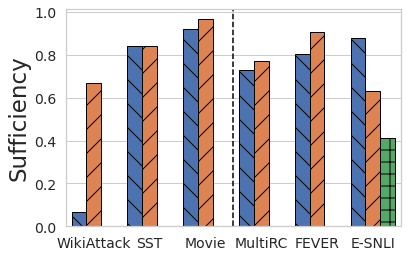

In [23]:
bar = sns.barplot(x="dataset", y="normalized_sufficiency", hue="class", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Sufficiency", legend_loc="upper left", legend_frameon=True,
                 bbox_to_anchor=(1.04,1), add_legend=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/class_wise/normalized_sufficiency.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Normalized Comprehensiveness

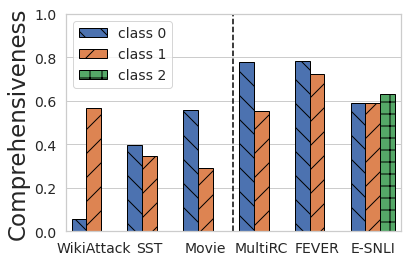

In [24]:
bar = sns.barplot(x="dataset", y="normalized_comprehensiveness", hue="class", data=plot_data_df, palette='colorblind')
pretty_histogram(bar, xlabel="", ylabel="Comprehensiveness", legend_loc="best", legend_frameon=True,
                 bbox_to_anchor=(1.04,1))
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/class_wise/normalized_comprehensiveness.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Boxplot

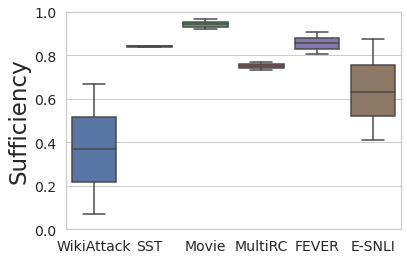

In [28]:
box = sns.boxplot(x="dataset", y="normalized_sufficiency", data=plot_data_df)
plt.ylabel("Sufficiency", fontsize=LABELSIZE)
plt.xlabel("", fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/box_plot/normalized_sufficiency.png", bbox_inches = 'tight', dpi=300)
plt.show()

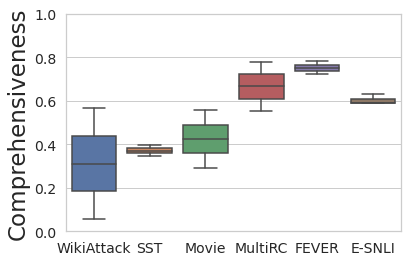

In [29]:
box = sns.boxplot(x="dataset", y="normalized_comprehensiveness", data=plot_data_df)
plt.ylabel("Comprehensiveness", fontsize=LABELSIZE)
plt.xlabel("", fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/box_plot/normalized_comprehensiveness.png", bbox_inches = 'tight', dpi=300)
plt.show()

# Fig 5 Epoch wise

## Plotting Data

In [10]:
datasets = ["wikiattack", "sst", "movies", "multirc", "fever", "esnli"]
plot_data = {"dataset": [], "accuracy": [], "clipped_sufficiency": [], "clipped_comprehensiveness": [],
            "normalized_sufficiency": [], "normalized_comprehensiveness": [], "epoch": []}
model_name="roberta"
for dataset in datasets:
    epoch_wise_load_dir = os.path.join(os.path.join(OUTPUT_DIR, model_name), "d="+dataset+"_hdp=0.1_lr=2e-05_nte=5")
    LOAD_DIR_LIST = [os.path.join(epoch_wise_load_dir, "epoch-0")]
    LOAD_DIR_LIST = LOAD_DIR_LIST + [os.path.join(epoch_wise_load_dir, name) for name in
                                     os.listdir(epoch_wise_load_dir) if "checkpoint-" in name]
    epoch = 0
    for epoch_feature_path in LOAD_DIR_LIST:
        feature_df = pd.read_csv(os.path.join(epoch_feature_path, "feature.csv"))
        y_hat = feature_df["predicted_classes"].to_numpy()
        y = feature_df["true_classes"].to_numpy()
        prob_y_hat = feature_df["prob_y_hat"].to_numpy()
        prob_y_hat_alpha = feature_df["prob_y_hat_alpha"].to_numpy()
        prob_y_hat_alpha_comp = feature_df["prob_y_hat_alpha_comp"].to_numpy()
        null_difference = feature_df["null_diff"].to_numpy()
        
        clipped_sufficiency = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                             prob_y_hat_alpha=prob_y_hat_alpha,
                                             normalization=False)
        
        clipped_comprehensiveness = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                                    prob_y_hat_alpha=prob_y_hat_alpha_comp,
                                                    fidelity_type="comprehensiveness",
                                                    normalization=False)
        
        normalized_sufficiency = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                     prob_y_hat_alpha=prob_y_hat_alpha,
                                     null_difference=null_difference,
                                     normalization=True)

        normalized_comprehensiveness = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                                    prob_y_hat_alpha=prob_y_hat_alpha_comp,
                                                    fidelity_type="comprehensiveness",
                                                    null_difference=null_difference,
                                                    normalization=True)
        plot_data["dataset"].append(lowercase_to_abs[dataset])
        plot_data["accuracy"].append(mt.accuracy_score(y, y_hat))
        plot_data["clipped_sufficiency"].append(clipped_sufficiency)
        plot_data["epoch"].append(epoch)
        plot_data["clipped_comprehensiveness"].append(clipped_comprehensiveness)
#         plot_data["null_difference"].append(np.mean(null_diff))
        plot_data["normalized_sufficiency"].append(normalized_sufficiency)
        plot_data["normalized_comprehensiveness"].append(normalized_comprehensiveness)
        epoch += 1
plot_data_df = pd.DataFrame(plot_data)

In [11]:
plot_data_df

,dataset,accuracy,clipped_sufficiency,clipped_comprehensiveness,normalized_sufficiency,normalized_comprehensiveness,epoch
0,WikiAttack,0.513,0.999,3.900e-04,0.000,0.000,0
1,WikiAttack,0.828,0.565,2.672e-01,0.385,0.298,1
2,WikiAttack,0.833,0.646,2.800e-01,0.390,0.308,2
3,WikiAttack,0.848,0.867,2.930e-01,0.376,0.318,3
4,WikiAttack,0.826,0.906,2.530e-01,0.321,0.284,4
5,WikiAttack,0.843,0.806,2.875e-01,0.391,0.321,5
6,SST,0.501,0.999,5.993e-04,0.000,0.000,0
7,SST,0.930,0.856,3.237e-01,0.842,0.385,1
8,SST,0.938,0.853,3.200e-01,0.832,0.398,2
9,SST,0.951,0.847,3.257e-01,0.841,0.371,3


## Accuracy

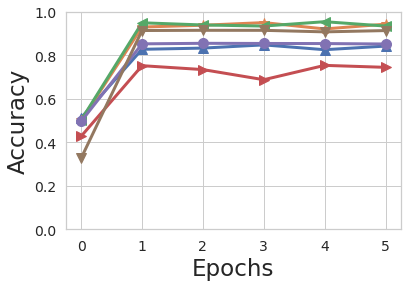

In [12]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["epoch"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["accuracy"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('Epochs', fontsize=LABELSIZE)
plt.ylabel('Accuracy', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0, 1)
plt.legend('', frameon=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/epoch_wise/accuracy.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Sufficiency

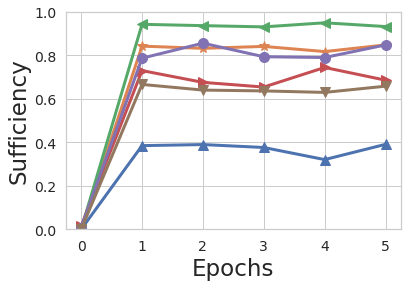

In [13]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["epoch"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["normalized_sufficiency"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('Epochs', fontsize=LABELSIZE)
plt.ylabel('Sufficiency', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0, 1)
plt.legend('', frameon=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/epoch_wise/normalized_sufficiency.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Comprehensiveness

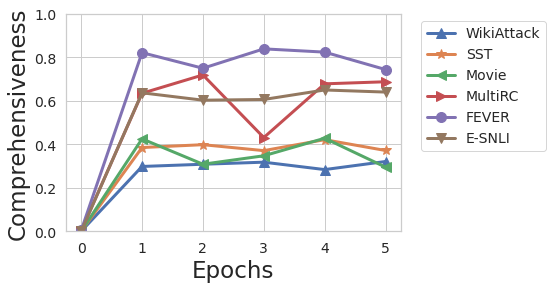

In [15]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["epoch"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["normalized_comprehensiveness"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('Epochs', fontsize=LABELSIZE)
plt.ylabel('Comprehensiveness', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/epoch_wise/normalized_comprehensiveness.png", bbox_inches = 'tight', dpi=300)
plt.show()

# Fig 6

## Plotting Data

In [6]:
datasets = ["wikismall", "sst", "movies", "multirc", "fever", "esnli"] # change this to wikiattack
reduced_datasets = ["wikismallred", "sstred", "moviesred", "multircred", "feverred", "esnlired"]

plot_data = {"dataset": [], "accuracy": [], "rationale": []}
model_name = "roberta"

output_dir = os.path.join(OUTPUT_DIR, model_name)

for idx, dataset in enumerate(datasets):
    feature_dir = os.path.join(output_dir, dataset)
    feature_df = pd.read_csv(os.path.join(feature_dir, "feature.csv"))

    y = feature_df["true_classes"].to_numpy()
    y_hat = feature_df["predicted_classes"].to_numpy()
    y_hat_alpha = feature_df["y_hat_alpha"].to_numpy()
    
    plot_data["dataset"].append(lowercase_to_abs[dataset])
    plot_data["accuracy"].append(mt.accuracy_score(y, y_hat))
    plot_data["rationale"].append("No rationale")
    
    plot_data["dataset"].append(lowercase_to_abs[dataset])
    plot_data["accuracy"].append(mt.accuracy_score(y, y_hat_alpha))
    plot_data["rationale"].append("Eval rationale")
    
    feature_reduced_dir = os.path.join(output_dir, reduced_datasets[idx])
    reduced_feature_df = pd.read_csv(os.path.join(feature_reduced_dir, "feature.csv"))
    display(reduced_feature_df)
    
    y = reduced_feature_df["true_classes"].to_numpy()
    y_hat = reduced_feature_df["predicted_classes"].to_numpy()
    
    plot_data["dataset"].append(lowercase_to_abs[dataset])
    plot_data["accuracy"].append(mt.accuracy_score(y, y_hat))
    plot_data["rationale"].append("Train-eval rationale")

plot_data_df = pd.DataFrame(plot_data)

,Unnamed: 0,true_classes,predicted_classes
0,0,1,1
1,1,0,1
2,2,1,1
3,3,1,1
4,4,0,1
...,...,...,...
145,145,0,1
146,146,1,1
147,147,1,1
148,148,0,1


,Unnamed: 0,id,prob_y_hat,prob_y_hat_alpha,y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes,zero_probs
0,0,870.0,0.996,0.996,1.0,0.996,0.566,1.0,1.0,[0.56903106 0.43096897]
1,1,2178.0,0.986,0.027,0.0,0.997,0.555,0.0,1.0,[0.56903106 0.43096897]
2,2,697.0,0.998,0.007,0.0,0.999,0.567,1.0,1.0,[0.56903106 0.43096897]
3,3,1073.0,0.997,0.996,0.0,0.995,0.428,0.0,0.0,[0.56903106 0.43096897]
4,4,1023.0,0.996,0.998,1.0,0.971,0.565,1.0,1.0,[0.56903106 0.43096897]
...,...,...,...,...,...,...,...,...,...,...
1816,1816,771.0,0.878,0.015,1.0,0.487,0.309,1.0,0.0,[0.56903076 0.4309692 ]
1817,1817,1093.0,0.998,0.997,0.0,0.175,0.429,0.0,0.0,[0.56903076 0.4309692 ]
1818,1818,1346.0,0.996,0.987,0.0,0.994,0.427,0.0,0.0,[0.56903076 0.4309692 ]
1819,1819,78.0,0.998,0.005,0.0,0.996,0.567,1.0,1.0,[0.56903076 0.4309692 ]


,Unnamed: 0,id,prob_y_hat,prob_y_hat_alpha,y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes,zero_probs
0,0,posR_983.txt,0.999,0.998,1.0,1.000,3.024e-04,1.0,1.0,[0.00120128 0.9987987 ]
1,1,posR_970.txt,1.000,0.999,1.0,1.000,1.075e-03,1.0,1.0,[0.00120128 0.9987987 ]
2,2,posR_950.txt,1.000,0.999,1.0,1.000,1.057e-03,1.0,1.0,[0.00120128 0.9987987 ]
3,3,negR_955.txt,1.000,1.000,0.0,1.000,9.987e-01,0.0,0.0,[0.00120128 0.9987987 ]
4,4,negR_920.txt,1.000,1.000,0.0,1.000,9.986e-01,0.0,0.0,[0.00120128 0.9987987 ]
...,...,...,...,...,...,...,...,...,...,...
194,194,posR_932.txt,0.998,0.999,1.0,0.998,0.000e+00,1.0,1.0,[0.00120129 0.9987987 ]
195,195,negR_924.txt,1.000,1.000,0.0,1.000,9.986e-01,0.0,0.0,[0.00120129 0.9987987 ]
196,196,posR_989.txt,0.997,1.000,1.0,0.972,0.000e+00,1.0,1.0,[0.00120129 0.9987987 ]
197,197,posR_953.txt,1.000,0.003,0.0,1.000,1.013e-03,1.0,1.0,[0.00120129 0.9987987 ]


,Unnamed: 0,id,prob_y_hat,prob_y_hat_alpha,y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes,zero_probs
0,0,History-Anthropology_oanc-HistoryMallorca-6.tx...,0.976,0.052,1.0,0.013,0.930,0.0,0.0,[0.04649411 0.9535059 ]
1,1,Society_Law_and_Justice_oanc-grants_fail_to_co...,0.998,0.978,0.0,0.002,0.952,0.0,0.0,[0.04649411 0.9535059 ]
2,2,Fiction-stories-masc-A_Wasted_Day-11.txt:9:5,0.998,0.003,1.0,0.998,0.952,1.0,0.0,[0.04649411 0.9535059 ]
3,3,News_CNN_cnn-3b659823a1b4208f0990ed2db4a293095...,0.977,0.997,1.0,0.003,0.024,1.0,1.0,[0.04649411 0.9535059 ]
4,4,Science-textbook_science-g3-28.txt:0:3,0.997,0.954,1.0,0.997,0.044,1.0,1.0,[0.04649411 0.9535059 ]
...,...,...,...,...,...,...,...,...,...,...
4843,4843,Science-textbook_science-g5-88.txt:12:0,0.997,0.954,1.0,0.997,0.044,1.0,1.0,[0.04649411 0.9535059 ]
4844,4844,Sept11-reports_oanc-chapter-3-2.txt:10:4,0.998,0.002,1.0,0.990,0.952,0.0,0.0,[0.04649411 0.9535059 ]
4845,4845,wikiMovieSummaries-18640799.txt:12:0,0.998,0.954,1.0,0.998,0.044,1.0,1.0,[0.04649411 0.9535059 ]
4846,4846,Society_Law_and_Justice_oanc-Attorney_gives_hi...,0.997,0.995,1.0,0.997,0.043,1.0,1.0,[0.04649411 0.9535059 ]


,Unnamed: 0,id,prob_y_hat,prob_y_hat_alpha,y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes,zero_probs
0,0,32338.0,0.997,0.001,1.0,0.991,0.741,0.0,0.0,[0.25629377 0.7437063 ]
1,1,179834.0,1.000,0.077,0.0,1.000,0.256,1.0,1.0,[0.25629377 0.7437063 ]
2,2,162745.0,1.000,0.744,1.0,1.000,0.256,1.0,1.0,[0.25629377 0.7437063 ]
3,3,84694.0,0.998,0.998,0.0,0.256,0.741,0.0,0.0,[0.25629377 0.7437063 ]
4,4,38107.0,0.991,0.010,1.0,0.992,0.735,0.0,0.0,[0.25629377 0.7437063 ]
...,...,...,...,...,...,...,...,...,...,...
6106,6106,165110.0,0.984,0.256,1.0,0.984,0.728,0.0,0.0,[0.25629377 0.7437063 ]
6107,6107,59001.0,0.999,0.744,1.0,0.999,0.255,1.0,1.0,[0.25629377 0.7437063 ]
6108,6108,90894.0,1.000,0.744,1.0,1.000,0.256,1.0,1.0,[0.25629377 0.7437063 ]
6109,6109,154633.0,1.000,0.994,1.0,1.000,0.256,1.0,1.0,[0.25629377 0.7437063 ]


,Unnamed: 0,id,prob_y_hat,prob_y_hat_alpha,y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes,zero_probs
0,0,206051614.jpg#4r1n,1.000,3.652e-03,1.0,1.000,0.996,2.0,2.0,[0.30571377 0.69063383 0.00365236]
1,1,4557545329.jpg#0r1n,1.000,3.652e-03,1.0,1.000,0.996,2.0,2.0,[0.30571377 0.69063383 0.00365236]
2,2,2863186021.jpg#0r1e,0.992,5.179e-07,2.0,0.985,0.302,1.0,1.0,[0.30571377 0.69063383 0.00365236]
3,3,3182504961.jpg#1r1e,1.000,9.957e-01,1.0,0.996,0.309,1.0,1.0,[0.30571377 0.69063383 0.00365236]
4,4,2437798869.jpg#0r1e,0.997,6.906e-01,1.0,0.997,0.306,1.0,1.0,[0.30571377 0.69063383 0.00365236]
...,...,...,...,...,...,...,...,...,...,...
9802,9802,4126111436.jpg#4r1n,1.000,3.652e-03,1.0,1.000,0.996,2.0,2.0,[0.30571365 0.690634 0.00365233]
9803,9803,3879971251.jpg#0r1c,1.000,3.057e-01,1.0,1.000,0.694,0.0,0.0,[0.30571365 0.690634 0.00365233]
9804,9804,3184108879.jpg#1r1n,0.999,3.057e-01,1.0,0.999,0.693,1.0,0.0,[0.30571365 0.690634 0.00365233]
9805,9805,4571889191.jpg#2r1c,1.000,3.057e-01,1.0,1.000,0.694,0.0,0.0,[0.30571365 0.690634 0.00365233]


## Accuracy

In [7]:
# Doubt about wikismall
# trained on wikiattack and tested on wikismall

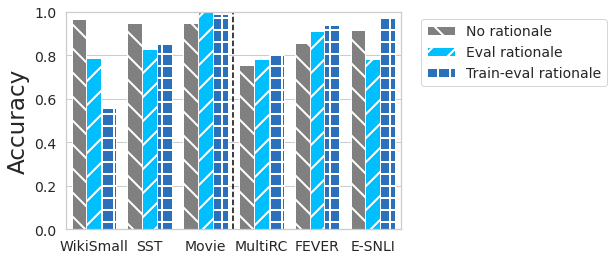

In [34]:
bar = sns.barplot(x="dataset", y="accuracy", hue="rationale", data=plot_data_df, palette='colorblind')
pretty_oracle_histogram(bar)
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/oracle_acc.png", bbox_inches = 'tight', dpi=300)
plt.show()

# Fig 7

## Config for Sam's code(will change later)

In [34]:
dataset_codes = ["sst",'movies','multirc','esnli','fever','wikiattack']
datasets = ["Stanford treebank", "movie reviews", "MultiRC", "E-SNLI", "FEVER", "Wikipedia personal attacks", "Wikipedia personal attacks (small)"]
datasetabs = ["SST", "Movie", "MultiRC", "E-SNLI", "FEVER", "WikiAttack", "WikiSmall"]
dataset_ab_dict = {}
for i in range(len(datasets)):
    dataset_ab_dict[datasets[i]] = datasetabs[i]
markers = ["^", "*", "<", ">", "o", "v",'v']
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

dataset_colors = {}
dataset_colors_idx = {}
dataset_markers = {}
acc_labels = {}

for i in range(len(dataset_codes)):
    dataset_colors[dataset_codes[i]] = colors[i]
    dataset_markers[dataset_codes[i]] = markers[i]
    acc_labels[dataset_codes[i]] = datasetabs[i]
    dataset_colors_idx[i] = colors[i]

## Plotting Data

In [37]:
# experiment_directory = '/data/sam/mita/output/evaluating_human_rationales/roberta/'
experiment_directory = '/data/sam/mita/output/final_roberta_models/roberta/'


# model_dirs = ['d=sst_hdp=0.1_lr=2e-05_nte=5',
#               'd=movies_hdp=0.1_lr=2e-05_nte=5',
#               'd=multirc_hdp=0.1_lr=2e-05_nte=5',
#               'd=fever_hdp=0.1_lr=2e-05_nte=5',
#               'd=esnli_hdp=0.1_lr=2e-05_nte=5',
#               'd=wikiattack_hdp=0.1_lr=2e-05_nte=5'
#              ]

model_dirs = ['d=sst',
              'd=movies',
              'd=multirc',
              'd=fever',
              'd=esnli',
              'd=wikiattack'
             ]

def subdir_paths(dir_path):
	try:
		filenames = os.listdir(dir_path)
		paths = [(filename, os.path.join(dir_path, filename)) for filename in filenames]
		subdir_paths = [(filename, filepath) for filename, filepath in paths if os.path.isdir(filepath)]
		return sorted(subdir_paths, key=lambda t: t[0])
	except:
		return []
    
def parse_combo_name(combo_name, abb_dict=None):
#     print(combo_name)
    pieces = [piece.split('_') for piece in combo_name.split('=')]
#     print(pieces)
    valdict = {}
    for i in range(1,len(pieces)):
#         print(pieces[i-1][-1])
#         print('_'.join(pieces[i][:-1]))
        key = pieces[i-1][-1]
        value = '_'.join(pieces[i][:-1]) if i < len(pieces)-1 else '_'.join(pieces[i])
        if abb_dict is not None and key in abb_dict:
            key = abb_dict[key]
        valdict[key] = value
        
    return valdict

dfs=[]
for model_dir in model_dirs:
    combo = parse_combo_name(model_dir)
    print(combo)
    if "wikiattack" in model_dir:
        curve_directory = "/data/sam/mita/output/wiki_regenerating_curves/roberta/d=wikiattack/fidelity_curves"
    else:
        curve_directory = os.path.join(experiment_directory, model_dir, 'fidelity_curves')
    for occlusion_rate, occlusion_dir in subdir_paths(curve_directory):
        print('\t',occlusion_rate)
        for sample_num, sample_dir in subdir_paths(occlusion_dir):
            print('\t\t',sample_num)
            try:
                df = pd.read_csv(os.path.join(sample_dir,'feature.csv'),index_col=0)
                df['occlusion_rate'] = float(occlusion_rate)
                df['sample_num'] = int(sample_num)
                df['combo_name'] = model_dir
                for key, value in combo.items():
                    df[key] = value
                dfs.append(df)
                acc = mt.accuracy_score(df['true_classes'],df['predicted_classes'])
                df['acc'] = acc
            except Exception as ex:
                print(ex)

all_df = pd.concat(dfs,axis=0)

all_df['raw_sufficiency'] = 1-(all_df['prob_y_hat'] - all_df['prob_y_hat_alpha'])
# all_df['clipped_sufficiency'] = 1-np.clip(all_df['raw_sufficiency'],0,1)
# all_df['clipped_0_sufficiency'] = 1-np.clip(all_df['null_diff'],0,1)

# all_df['normalized_sufficiency'] = (all_df['clipped_sufficiency']-all_df['clipped_0_sufficiency'])/(1-all_df['clipped_0_sufficiency'])
# with pd.option_context('mode.use_inf_as_na', True):
#     all_df['normalized_sufficiency'].fillna(0.0, inplace=True)


all_df['raw_comprehensiveness'] = all_df['prob_y_hat'] - all_df['prob_y_hat_alpha_comp']
# all_df['clipped_comprehensiveness'] = np.clip(all_df['raw_comprehensiveness'],0,1)
# all_df['clipped_1_comprehensiveness'] = np.clip(all_df['null_diff'],0,1)

# all_df['normalized_comprehensiveness'] = all_df['clipped_comprehensiveness']/all_df['clipped_1_comprehensiveness']
# with pd.option_context('mode.use_inf_as_na', True):
#     all_df['normalized_comprehensiveness'].fillna(0.0, inplace=True)


# fidelity_calculator = Fidelity(experiment_id='fidelity_curve_plotting_2')
all_df['normalized_sufficiency']  = fidelity_calculator.compute(
	prob_y_hat=all_df['prob_y_hat'].values,
	prob_y_hat_alpha=all_df['prob_y_hat_alpha'].values,
	null_difference=all_df['null_diff'].values,
	normalization=True,
    reduction=None)

all_df['normalized_comprehensiveness'] = fidelity_calculator.compute(
	prob_y_hat=all_df['prob_y_hat'].values,
	prob_y_hat_alpha=all_df['prob_y_hat_alpha_comp'].values,
	null_difference=all_df['null_diff'].values,
	fidelity_type="comprehensiveness",
	normalization=True,
reduction=None)

all_df['clipped_sufficiency']  = fidelity_calculator.compute(
	prob_y_hat=all_df['prob_y_hat'].values,
	prob_y_hat_alpha=all_df['prob_y_hat_alpha'].values,
	null_difference=all_df['null_diff'].values,
	normalization=False,
reduction=None)

all_df['clipped_comprehensiveness'] = fidelity_calculator.compute(
	prob_y_hat=all_df['prob_y_hat'].values,
	prob_y_hat_alpha=all_df['prob_y_hat_alpha_comp'].values,
	null_difference=all_df['null_diff'].values,
	fidelity_type="comprehensiveness",
	normalization=False,
reduction=None)

with pd.option_context('mode.use_inf_as_na', True):
    na_df = all_df[all_df['normalized_sufficiency'].isna()]

meaned_across_points = all_df.groupby(['combo_name', 'occlusion_rate','sample_num','d'],as_index=False).mean()

meaned_across_samples = meaned_across_points.groupby(['combo_name', 'occlusion_rate','d'],as_index=False).mean()

{'d': 'sst'}
	 0.0
		 0
	 0.05
		 0
	 0.1
		 0
	 0.15
		 0
	 0.2
		 0
	 0.25
		 0
	 0.3
		 0
	 0.35
		 0
	 0.4
		 0
	 0.45
		 0
	 0.5
		 0
	 0.55
		 0
	 0.6
		 0
	 0.65
		 0
	 0.7
		 0
	 0.75
		 0
	 0.8
		 0
	 0.85
		 0
	 0.9
		 0
	 0.95
		 0
	 1.0
		 0
{'d': 'movies'}
	 0.0
		 0
	 0.05
		 0
	 0.1
		 0
	 0.15
		 0
	 0.2
		 0
	 0.25
		 0
	 0.3
		 0
	 0.35
		 0
	 0.4
		 0
	 0.45
		 0
	 0.5
		 0
	 0.55
		 0
	 0.6
		 0
	 0.65
		 0
	 0.7
		 0
	 0.75
		 0
	 0.8
		 0
	 0.85
		 0
	 0.9
		 0
	 0.95
		 0
	 1.0
		 0
{'d': 'multirc'}
	 0.0
		 0
	 0.05
		 0
	 0.1
		 0
	 0.15
		 0
	 0.2
		 0
	 0.25
		 0
	 0.3
		 0
	 0.35
		 0
	 0.4
		 0
	 0.45
		 0
	 0.5
		 0
	 0.55
		 0
	 0.6
		 0
	 0.65
		 0
	 0.7
		 0
	 0.75
		 0
	 0.8
		 0
	 0.85
		 0
	 0.9
		 0
	 0.95
		 0
	 1.0
		 0
{'d': 'fever'}
	 0.0
		 0
	 0.05
		 0
	 0.1
		 0
	 0.15
		 0
	 0.2
		 0
	 0.25
		 0
	 0.3
		 0
	 0.35
		 0
	 0.4
		 0
	 0.45
		 0
	 0.5
		 0
	 0.55
		 0
	 0.6
		 0
	 0.65
		 0
	 0.7
		 0
	 0.75
		 0
	 0.8
		 0
	 0.85
		 0
	 0.9
		 

<ipython-input-38-c020a3fde1af>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df['occlusion_rate'] = 1-dataset_df['occlusion_rate']


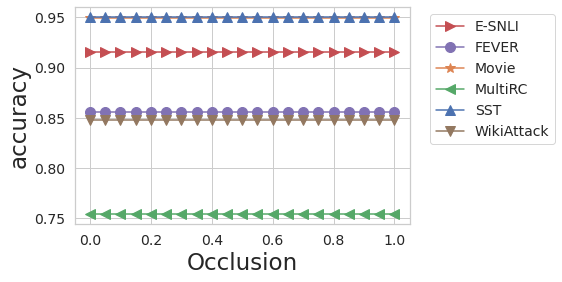

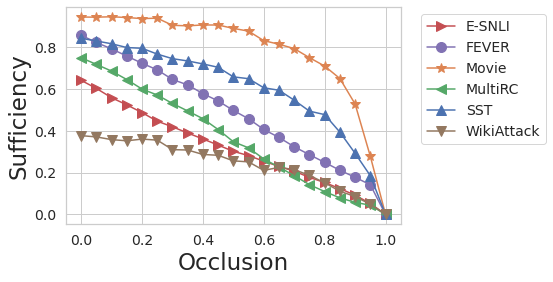

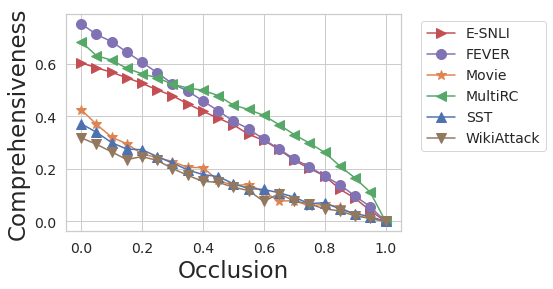

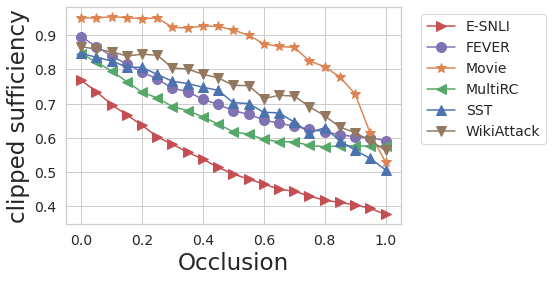

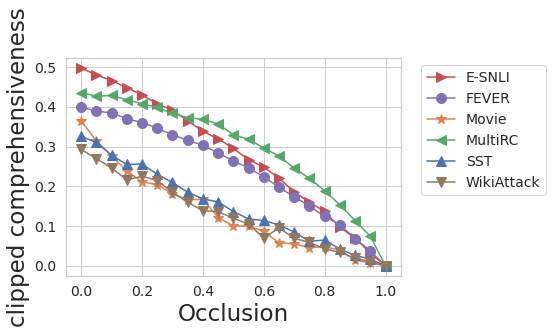

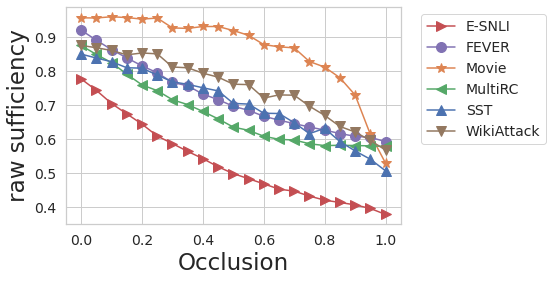

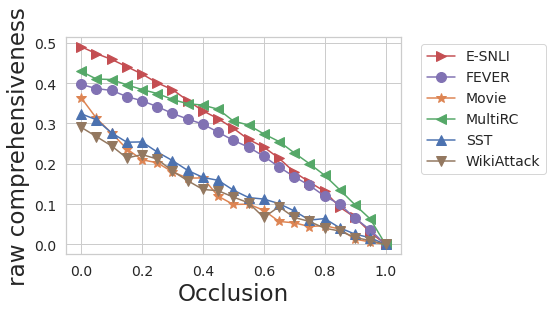

In [38]:
names_metrics = [
    ('accuracy','acc'),
    ('Sufficiency','normalized_sufficiency'),
    ('Comprehensiveness','normalized_comprehensiveness'),
    ('clipped sufficiency','clipped_sufficiency'),
    ('clipped comprehensiveness','clipped_comprehensiveness'),
    ('raw sufficiency','raw_sufficiency'),
    ('raw comprehensiveness','raw_comprehensiveness')]

for name, metric in names_metrics:

    for dataset in meaned_across_samples['d'].unique():
        dataset_df = meaned_across_samples[meaned_across_samples['d'] == dataset]
        dataset_df['occlusion_rate'] = 1-dataset_df['occlusion_rate']
        plt.errorbar(dataset_df['occlusion_rate'], 
            dataset_df[metric], 
            #                  yerr=error, 
            color=dataset_colors[dataset],
            marker=dataset_markers[dataset], 
            linestyle="solid", 
            ecolor=dataset_colors[dataset],
            markersize=MARKERSIZE, 
            label=acc_labels[dataset])


    plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
    plt.xlabel('Occlusion', fontsize=LABELSIZE)
    plt.ylabel(name, fontsize=LABELSIZE)
    plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
    plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
    plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/parsimony/"+metric+".png",
                bbox_inches = 'tight', dpi=300)
    plt.show()

# Prettifying code

In [8]:
def pretty_histogram(bar, xlabel, ylabel, legend_loc, legend_frameon=True, bbox_to_anchor=(1.04,1),
                    add_legend=True):
    for i,thisbar in enumerate(bar.patches):
        # Set a different hatch for each bar
        if i in [0, 1, 2, 3, 4, 5]:
            thisbar.set_color(dataset_colors_idx[0])
            thisbar.set_hatch('\\')
            thisbar.set_edgecolor('black')
        elif i in [6, 7, 8, 9, 10, 11]:
            thisbar.set_color(dataset_colors_idx[1])
            thisbar.set_hatch('/')
            thisbar.set_edgecolor('black')
        elif i in [12, 13, 14, 15, 16, 17]:
            thisbar.set_color(dataset_colors_idx[2])
            thisbar.set_hatch('+')
            thisbar.set_edgecolor('black')
        else:
            thisbar.set_color(dataset_colors_idx[3])
            thisbar.set_hatch('o')
            thisbar.set_edgecolor('black')
    plt.axvline(x=2.5, linestyle="dashed", color="black")
    # plt.ylim(0.6, 1)
    plt.ylabel(ylabel, fontsize=LABELSIZE)
    plt.xlabel(xlabel, fontsize=LABELSIZE)
    plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
    plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
    if add_legend:
        if legend_loc == "best":
            plt.legend(loc=legend_loc, fontsize=LEGENDLABELSIZE, frameon=legend_frameon)
        else:
            plt.legend(loc=legend_loc, fontsize=LEGENDLABELSIZE, frameon=legend_frameon,
                       bbox_to_anchor=bbox_to_anchor)
    else:
        plt.legend('', frameon=False)

In [9]:
def pretty_oracle_histogram(bar):
    color_scheme_oracle = ['gray', 'deepskyblue', '#2c6fbb']
    mpl.rcParams['hatch.linewidth'] = 2.0
    for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
        if i in [0, 1, 2, 3, 4, 5]:
            thisbar.set_color(color_scheme_oracle[0])
            thisbar.set_hatch('\\')
            thisbar.set_edgecolor('white')
        elif i in [6, 7, 8, 9, 10, 11]:
            thisbar.set_color(color_scheme_oracle[1])
            thisbar.set_hatch('/')
            thisbar.set_edgecolor('white')
        else:
            thisbar.set_color(color_scheme_oracle[2])
            thisbar.set_hatch('+')
            thisbar.set_edgecolor('white')
    plt.axvline(x=2.5, linestyle="dashed", color="black")
    plt.ylabel("Accuracy", fontsize=LABELSIZE)
    plt.xlabel("", fontsize=LABELSIZE)
    plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
    plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
    plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)

# Appendix Plots

## Fig 11

### Plotting data

In [149]:
output_dir = os.path.join(OUTPUT_DIR, "logistic_regression")
datasets = ["wikiattack", "sst", "movies", "multirc", "fever", "esnli"]
plot_data = {"dataset": [], "accuracy": [], "sufficiency": [], "comprehensiveness": [], "C": []}
C_list = [0.001, 0.01, 0.1, 1, 10, 100]
for dataset in datasets:
    for dummy_C in C_list:
#         C=10_d=fever
        load_dir = "C="+str(dummy_C)+"_d="+dataset
        print(load_dir)
        C = float(load_dir.split('=')[1].split("_")[0])
        print(C)
        feature_df = pd.read_csv(os.path.join(output_dir, os.path.join(load_dir, "feature.csv")))
        display(feature_df)

        y_hat = feature_df["predicted_classes"].to_numpy()
        y = feature_df["true_classes"].to_numpy()
        prob_y_hat = feature_df["prob_y_hat"].to_numpy()
        prob_y_hat_alpha = feature_df["prob_y_hat_alpha"].to_numpy()
        prob_y_hat_alpha_comp = feature_df["prob_y_hat_alpha_comp"].to_numpy()
        null_difference = feature_df["null_diff"].to_numpy()

        normalized_sufficiency = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                             prob_y_hat_alpha=prob_y_hat_alpha,
                                             normalization=True, null_difference=null_difference)

        normalized_comprehensiveness = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                                    prob_y_hat_alpha=prob_y_hat_alpha_comp,
                                                    fidelity_type="comprehensiveness",
                                                    normalization=True, null_difference=null_difference)

        plot_data["dataset"].append(lowercase_to_abs[dataset])
        plot_data["C"].append(C)
        plot_data["accuracy"].append(mt.accuracy_score(y, y_hat))

        plot_data["sufficiency"].append(normalized_sufficiency)
        plot_data["comprehensiveness"].append(normalized_comprehensiveness)
plot_data_df = pd.DataFrame(plot_data)

C=0.001_d=wikiattack
0.001


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.866,0.865,0.866,2.151e-04,0,0
1,1,0.865,0.865,0.865,7.067e-06,0,0
2,2,0.865,0.865,0.865,8.282e-05,0,0
3,3,0.865,0.865,0.865,0.000e+00,0,0
4,4,0.866,0.865,0.866,2.450e-04,0,0
...,...,...,...,...,...,...,...
535,535,0.866,0.865,0.866,1.594e-04,0,0
536,536,0.865,0.865,0.865,0.000e+00,1,0
537,537,0.865,0.865,0.865,9.049e-05,1,0
538,538,0.865,0.865,0.865,4.632e-05,0,0


C=0.01_d=wikiattack
0.01


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.865,0.863,0.865,1.708e-03,0,0
1,1,0.863,0.863,0.863,5.841e-05,0,0
2,2,0.864,0.863,0.864,6.245e-04,0,0
3,3,0.863,0.863,0.863,0.000e+00,0,0
4,4,0.865,0.863,0.865,2.001e-03,0,0
...,...,...,...,...,...,...,...
535,535,0.864,0.863,0.864,1.145e-03,0,0
536,536,0.862,0.863,0.863,0.000e+00,1,0
537,537,0.864,0.863,0.864,4.949e-04,1,0
538,538,0.864,0.863,0.864,2.820e-04,0,0


C=0.1_d=wikiattack
0.1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.866,0.857,0.866,8.926e-03,0,0
1,1,0.858,0.857,0.858,4.237e-04,0,0
2,2,0.860,0.857,0.860,2.698e-03,0,0
3,3,0.851,0.851,0.857,0.000e+00,0,0
4,4,0.867,0.857,0.867,1.038e-02,0,0
...,...,...,...,...,...,...,...
535,535,0.861,0.857,0.861,4.027e-03,0,0
536,536,0.845,0.854,0.851,0.000e+00,1,0
537,537,0.856,0.857,0.856,0.000e+00,1,0
538,538,0.857,0.857,0.857,0.000e+00,0,0


C=1_d=wikiattack
1.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.883,0.851,0.883,0.031,0,0
1,1,0.854,0.851,0.854,0.003,0,0
2,2,0.859,0.851,0.859,0.008,0,0
3,3,0.811,0.811,0.851,0.000,0,0
4,4,0.878,0.851,0.878,0.027,0,0
...,...,...,...,...,...,...,...
535,535,0.853,0.851,0.853,0.002,0,0
536,536,0.758,0.828,0.812,0.000,1,0
537,537,0.831,0.847,0.835,0.000,1,0
538,538,0.844,0.851,0.844,0.000,0,0


C=10_d=wikiattack
10.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.938,0.855,0.938,0.083,0,0
1,1,0.866,0.855,0.866,0.010,0,0
2,2,0.883,0.855,0.883,0.028,0,0
3,3,0.580,0.580,0.855,0.000,0,0
4,4,0.901,0.855,0.901,0.045,0,0
...,...,...,...,...,...,...,...
535,535,0.865,0.855,0.865,0.009,0,0
536,536,0.598,0.260,0.270,0.454,1,1
537,537,0.828,0.847,0.834,0.000,1,0
538,538,0.835,0.855,0.835,0.000,0,0


C=100_d=wikiattack
100.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.983,0.873,0.983,0.110,0,0
1,1,0.892,0.873,0.892,0.020,0,0
2,2,0.920,0.873,0.920,0.048,0,0
3,3,0.908,0.908,0.127,0.781,0,1
4,4,0.923,0.873,0.923,0.050,0,0
...,...,...,...,...,...,...,...
535,535,0.926,0.873,0.926,0.054,0,0
536,536,0.976,0.519,0.433,0.849,1,1
537,537,0.869,0.856,0.880,0.000,1,0
538,538,0.841,0.873,0.841,0.000,0,0


C=0.001_d=sst
0.001


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.522,0.522,0.522,0.000e+00,1,1
1,1,0.522,0.522,0.522,0.000e+00,1,1
2,2,0.522,0.522,0.522,1.925e-06,1,1
3,3,0.522,0.522,0.522,0.000e+00,1,1
4,4,0.522,0.522,0.522,0.000e+00,1,1
...,...,...,...,...,...,...,...
1816,1816,0.522,0.522,0.522,6.564e-07,1,1
1817,1817,0.522,0.522,0.522,1.618e-06,1,1
1818,1818,0.522,0.522,0.522,1.231e-06,1,1
1819,1819,0.522,0.522,0.522,0.000e+00,1,1


C=0.01_d=sst
0.01


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.522,0.522,0.522,0.000e+00,1,1
1,1,0.522,0.522,0.522,0.000e+00,1,1
2,2,0.522,0.522,0.522,1.926e-05,1,1
3,3,0.522,0.522,0.522,0.000e+00,1,1
4,4,0.522,0.522,0.522,0.000e+00,1,1
...,...,...,...,...,...,...,...
1816,1816,0.522,0.522,0.522,6.572e-06,1,1
1817,1817,0.522,0.522,0.522,1.620e-05,1,1
1818,1818,0.522,0.522,0.522,1.231e-05,1,1
1819,1819,0.522,0.522,0.522,0.000e+00,1,1


C=0.1_d=sst
0.1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.521,0.522,0.521,0.000e+00,1,1
1,1,0.521,0.522,0.521,0.000e+00,1,1
2,2,0.522,0.522,0.522,1.907e-04,1,1
3,3,0.522,0.522,0.522,0.000e+00,1,1
4,4,0.522,0.522,0.522,0.000e+00,1,1
...,...,...,...,...,...,...,...
1816,1816,0.522,0.522,0.522,6.445e-05,1,1
1817,1817,0.522,0.522,0.522,1.615e-04,1,1
1818,1818,0.522,0.522,0.522,1.225e-04,1,1
1819,1819,0.522,0.522,0.522,0.000e+00,1,1


C=1_d=sst
1.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.519,0.522,0.518,0.000e+00,1,1
1,1,0.519,0.520,0.520,0.000e+00,1,1
2,2,0.523,0.523,0.521,1.888e-03,1,1
3,3,0.521,0.521,0.521,0.000e+00,1,1
4,4,0.520,0.521,0.521,0.000e+00,1,1
...,...,...,...,...,...,...,...
1816,1816,0.522,0.521,0.521,6.477e-04,1,1
1817,1817,0.523,0.522,0.522,1.602e-03,1,1
1818,1818,0.522,0.522,0.522,1.218e-03,1,1
1819,1819,0.521,0.521,0.521,0.000e+00,1,1


C=10_d=sst
10.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.503,0.529,0.493,0.000,1,1
1,1,0.501,0.512,0.507,0.000,1,1
2,2,0.535,0.535,0.519,0.016,1,1
3,3,0.516,0.518,0.520,0.000,1,1
4,4,0.510,0.516,0.514,0.000,1,1
...,...,...,...,...,...,...,...
1816,1816,0.525,0.520,0.521,0.006,1,1
1817,1817,0.534,0.527,0.524,0.015,1,1
1818,1818,0.530,0.524,0.523,0.011,1,1
1819,1819,0.514,0.516,0.517,0.000,1,1


C=100_d=sst
100.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.510,0.404,0.597,0.024,1,0
1,1,0.540,0.494,0.540,0.054,1,0
2,2,0.596,0.596,0.514,0.082,1,1
3,3,0.507,0.515,0.522,0.000,1,1
4,4,0.508,0.507,0.480,0.022,1,0
...,...,...,...,...,...,...,...
1816,1816,0.548,0.514,0.521,0.033,1,1
1817,1817,0.609,0.581,0.538,0.095,1,1
1818,1818,0.585,0.555,0.536,0.071,1,1
1819,1819,0.526,0.510,0.500,0.040,1,0


C=0.001_d=movies
0.001


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.500,0.498,0.500,1.863e-03,0,1
1,1,0.502,0.502,0.502,0.000e+00,0,0
2,2,0.500,0.498,0.500,1.956e-03,0,1
3,3,0.502,0.502,0.502,0.000e+00,0,0
4,4,0.502,0.502,0.502,5.499e-06,0,0
...,...,...,...,...,...,...,...
194,194,0.500,0.499,0.499,2.169e-03,1,1
195,195,0.502,0.502,0.502,0.000e+00,1,0
196,196,0.501,0.498,0.501,2.569e-03,1,1
197,197,0.501,0.498,0.501,2.494e-03,1,1


C=0.01_d=movies
0.01


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.500,0.513,0.504,0.000e+00,0,0
1,1,0.511,0.513,0.513,0.000e+00,0,0
2,2,0.501,0.487,0.502,1.352e-02,0,1
3,3,0.513,0.513,0.513,0.000e+00,0,0
4,4,0.513,0.513,0.513,1.254e-04,0,0
...,...,...,...,...,...,...,...
194,194,0.503,0.493,0.492,1.577e-02,1,1
195,195,0.511,0.513,0.512,0.000e+00,1,0
196,196,0.507,0.487,0.506,1.973e-02,1,1
197,197,0.506,0.487,0.507,1.896e-02,1,1


C=0.1_d=movies
0.1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.512,0.535,0.514,0.000,0,0
1,1,0.536,0.534,0.531,0.004,0,0
2,2,0.509,0.538,0.501,0.000,0,0
3,3,0.533,0.534,0.531,0.002,0,0
4,4,0.534,0.533,0.532,0.002,0,0
...,...,...,...,...,...,...,...
194,194,0.514,0.482,0.478,0.046,1,1
195,195,0.523,0.532,0.529,0.000,1,0
196,196,0.548,0.469,0.545,0.080,1,1
197,197,0.542,0.468,0.551,0.073,1,1


C=1_d=movies
1.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.600,0.548,0.573,0.067,0,0
1,1,0.579,0.541,0.534,0.046,0,0
2,2,0.583,0.560,0.542,0.051,0,0
3,3,0.532,0.540,0.525,0.000,0,0
4,4,0.541,0.538,0.532,0.009,0,0
...,...,...,...,...,...,...,...
194,194,0.609,0.572,0.515,0.141,1,1
195,195,0.512,0.470,0.487,0.044,1,1
196,196,0.715,0.475,0.693,0.247,1,1
197,197,0.697,0.468,0.728,0.229,1,1


C=10_d=movies
10.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.790,0.576,0.748,0.254,0,0
1,1,0.649,0.557,0.538,0.113,0,0
2,2,0.785,0.601,0.696,0.249,0,0
3,3,0.504,0.552,0.510,0.000,0,0
4,4,0.548,0.551,0.527,0.013,0,0
...,...,...,...,...,...,...,...
194,194,0.871,0.880,0.708,0.407,1,1
195,195,0.589,0.469,0.520,0.125,1,1
196,196,0.921,0.487,0.886,0.457,1,1
197,197,0.884,0.464,0.903,0.420,1,1


C=100_d=movies
100.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.951,0.645,0.918,0.381,0,0
1,1,0.724,0.607,0.559,0.154,0,0
2,2,0.960,0.684,0.866,0.390,0,0
3,3,0.564,0.416,0.490,0.134,0,1
4,4,0.577,0.598,0.542,0.007,0,0
...,...,...,...,...,...,...,...
194,194,0.983,0.990,0.914,0.553,1,1
195,195,0.692,0.440,0.552,0.263,1,1
196,196,0.992,0.475,0.981,0.562,1,1
197,197,0.982,0.438,0.983,0.552,1,1


C=0.001_d=multirc
0.001


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.560,0.556,0.558,0.005,1,0
1,1,0.560,0.556,0.558,0.004,1,0
2,2,0.560,0.556,0.558,0.004,1,0
3,3,0.560,0.556,0.558,0.004,0,0
4,4,0.560,0.556,0.558,0.004,0,0
...,...,...,...,...,...,...,...
4843,4843,0.558,0.556,0.557,0.002,0,0
4844,4844,0.558,0.556,0.557,0.003,0,0
4845,4845,0.558,0.556,0.557,0.003,1,0
4846,4846,0.558,0.556,0.557,0.003,1,0


C=0.01_d=multirc
0.01


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.562,0.551,0.557,0.011,1,0
1,1,0.562,0.551,0.557,0.012,1,0
2,2,0.562,0.551,0.557,0.011,1,0
3,3,0.562,0.551,0.557,0.011,0,0
4,4,0.562,0.551,0.557,0.011,0,0
...,...,...,...,...,...,...,...
4843,4843,0.554,0.551,0.552,0.003,0,0
4844,4844,0.553,0.551,0.552,0.003,0,0
4845,4845,0.553,0.551,0.552,0.003,1,0
4846,4846,0.553,0.551,0.552,0.003,1,0


C=0.1_d=multirc
0.1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.567,0.548,0.565,0.021,1,0
1,1,0.572,0.549,0.565,0.025,1,0
2,2,0.570,0.549,0.565,0.024,1,0
3,3,0.570,0.549,0.565,0.023,0,0
4,4,0.570,0.549,0.565,0.023,0,0
...,...,...,...,...,...,...,...
4843,4843,0.540,0.548,0.542,0.000,0,0
4844,4844,0.534,0.547,0.542,0.000,0,0
4845,4845,0.535,0.547,0.542,0.000,1,0
4846,4846,0.536,0.548,0.542,0.000,1,0


C=1_d=multirc
1.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.574,0.555,0.591,0.026,1,0
1,1,0.585,0.557,0.591,0.037,1,0
2,2,0.582,0.556,0.591,0.034,1,0
3,3,0.582,0.555,0.591,0.033,0,0
4,4,0.581,0.555,0.591,0.033,0,0
...,...,...,...,...,...,...,...
4843,4843,0.517,0.554,0.534,0.000,0,0
4844,4844,0.505,0.446,0.466,0.054,0,1
4845,4845,0.500,0.446,0.466,0.049,1,1
4846,4846,0.504,0.554,0.534,0.000,1,0


C=10_d=multirc
10.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.569,0.591,0.658,0.000,1,0
1,1,0.591,0.592,0.658,0.021,1,0
2,2,0.588,0.590,0.658,0.018,1,0
3,3,0.590,0.589,0.658,0.019,0,0
4,4,0.587,0.589,0.658,0.017,0,0
...,...,...,...,...,...,...,...
4843,4843,0.529,0.415,0.463,0.099,0,1
4844,4844,0.595,0.411,0.463,0.166,0,1
4845,4845,0.575,0.410,0.463,0.145,1,1
4846,4846,0.567,0.411,0.463,0.138,1,1


C=100_d=multirc
100.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.571,0.677,0.764,0.000,1,0
1,1,0.609,0.676,0.764,0.000,1,0
2,2,0.609,0.674,0.764,0.000,1,0
3,3,0.616,0.672,0.764,0.000,0,0
4,4,0.610,0.672,0.764,0.000,0,0
...,...,...,...,...,...,...,...
4843,4843,0.651,0.345,0.475,0.285,0,1
4844,4844,0.765,0.335,0.475,0.399,0,1
4845,4845,0.733,0.334,0.475,0.367,1,1
4846,4846,0.721,0.336,0.475,0.355,1,1


C=0.001_d=fever
0.001


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.728,0.720,0.727,8.174e-03,1,1
1,1,0.720,0.720,0.720,0.000e+00,0,1
2,2,0.720,0.720,0.720,1.781e-05,0,1
3,3,0.721,0.720,0.721,8.193e-04,1,1
4,4,0.727,0.721,0.721,6.786e-03,1,1
...,...,...,...,...,...,...,...
6106,6106,0.721,0.720,0.720,2.936e-04,0,1
6107,6107,0.721,0.720,0.720,4.684e-04,1,1
6108,6108,0.720,0.720,0.720,2.155e-05,0,1
6109,6109,0.720,0.720,0.720,2.318e-05,0,1


C=0.01_d=fever
0.01


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.733,0.720,0.732,1.372e-02,1,1
1,1,0.719,0.719,0.720,0.000e+00,0,1
2,2,0.718,0.720,0.718,0.000e+00,0,1
3,3,0.723,0.720,0.722,3.620e-03,1,1
4,4,0.733,0.722,0.720,1.300e-02,1,1
...,...,...,...,...,...,...,...
6106,6106,0.721,0.720,0.720,1.059e-03,0,1
6107,6107,0.712,0.720,0.713,0.000e+00,1,1
6108,6108,0.719,0.720,0.719,0.000e+00,0,1
6109,6109,0.720,0.720,0.720,6.105e-05,0,1


C=0.1_d=fever
0.1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.713,0.720,0.714,0.000e+00,1,1
1,1,0.718,0.719,0.720,0.000e+00,0,1
2,2,0.716,0.721,0.716,0.000e+00,0,1
3,3,0.726,0.721,0.724,5.972e-03,1,1
4,4,0.755,0.730,0.721,3.455e-02,1,1
...,...,...,...,...,...,...,...
6106,6106,0.720,0.720,0.721,0.000e+00,0,1
6107,6107,0.693,0.720,0.698,0.000e+00,1,1
6108,6108,0.721,0.721,0.720,6.126e-04,0,1
6109,6109,0.720,0.720,0.720,0.000e+00,0,1


C=1_d=fever
1.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.644,0.717,0.654,0.000,1,1
1,1,0.713,0.715,0.718,0.000,0,1
2,2,0.719,0.723,0.713,0.000,0,1
3,3,0.721,0.721,0.719,0.002,1,1
4,4,0.790,0.746,0.718,0.070,1,1
...,...,...,...,...,...,...,...
6106,6106,0.710,0.714,0.716,0.000,0,1
6107,6107,0.671,0.720,0.674,0.000,1,1
6108,6108,0.728,0.722,0.724,0.008,0,1
6109,6109,0.715,0.715,0.720,0.000,0,1


C=10_d=fever
10.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.520,0.711,0.557,0.000,1,1
1,1,0.706,0.708,0.717,0.000,0,1
2,2,0.733,0.725,0.717,0.014,0,1
3,3,0.715,0.723,0.711,0.000,1,1
4,4,0.782,0.759,0.694,0.064,1,1
...,...,...,...,...,...,...,...
6106,6106,0.694,0.706,0.710,0.000,0,1
6107,6107,0.614,0.722,0.616,0.000,1,1
6108,6108,0.739,0.722,0.733,0.021,0,1
6109,6109,0.701,0.701,0.718,0.000,0,1


C=100_d=fever
100.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.648,0.301,0.571,3.625e-01,1,0
1,1,0.698,0.698,0.714,0.000e+00,0,1
2,2,0.746,0.721,0.726,3.132e-02,0,1
3,3,0.715,0.725,0.704,6.982e-04,1,1
4,4,0.713,0.755,0.656,0.000e+00,1,1
...,...,...,...,...,...,...,...
6106,6106,0.683,0.697,0.705,0.000e+00,0,1
6107,6107,0.543,0.721,0.548,0.000e+00,1,1
6108,6108,0.742,0.716,0.738,2.809e-02,0,1
6109,6109,0.681,0.681,0.714,0.000e+00,0,1


C=0.001_d=esnli
0.001


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.334,0.334,0.334,0.000e+00,0,1
1,1,0.334,0.334,0.334,1.065e-04,1,1
2,2,0.334,0.334,0.334,0.000e+00,2,1
3,3,0.334,0.334,0.334,0.000e+00,0,1
4,4,0.334,0.334,0.334,3.275e-05,1,1
...,...,...,...,...,...,...,...
9802,9802,0.334,0.334,0.334,0.000e+00,1,1
9803,9803,0.334,0.334,0.334,0.000e+00,2,1
9804,9804,0.334,0.334,0.334,0.000e+00,0,1
9805,9805,0.334,0.334,0.334,1.388e-04,1,1


C=0.01_d=esnli
0.01


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.335,0.335,0.335,0.000e+00,0,1
1,1,0.337,0.335,0.337,1.124e-03,1,1
2,2,0.335,0.335,0.335,0.000e+00,2,1
3,3,0.334,0.335,0.333,3.055e-04,0,0
4,4,0.336,0.336,0.335,3.535e-04,1,1
...,...,...,...,...,...,...,...
9802,9802,0.337,0.332,0.336,6.131e-03,1,2
9803,9803,0.334,0.331,0.334,2.794e-03,2,2
9804,9804,0.335,0.332,0.335,4.296e-03,0,2
9805,9805,0.337,0.335,0.337,1.344e-03,1,1


C=0.1_d=esnli
0.1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.343,0.345,0.344,0.000,0,1
1,1,0.359,0.346,0.359,0.013,1,1
2,2,0.342,0.344,0.344,0.000,2,1
3,3,0.336,0.343,0.327,0.002,0,0
4,4,0.350,0.353,0.343,0.004,1,1
...,...,...,...,...,...,...,...
9802,9802,0.375,0.327,0.362,0.054,1,2
9803,9803,0.345,0.320,0.345,0.024,2,2
9804,9804,0.359,0.324,0.354,0.038,0,2
9805,9805,0.357,0.344,0.359,0.011,1,1


C=1_d=esnli
1.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.363,0.374,0.363,0.000,0,1
1,1,0.470,0.378,0.474,0.091,1,1
2,2,0.357,0.363,0.373,0.000,2,1
3,3,0.376,0.281,0.381,0.090,0,2
4,4,0.416,0.437,0.360,0.037,1,1
...,...,...,...,...,...,...,...
9802,9802,0.563,0.310,0.486,0.277,1,2
9803,9803,0.411,0.281,0.415,0.126,2,2
9804,9804,0.515,0.318,0.468,0.230,0,2
9805,9805,0.415,0.362,0.433,0.037,1,1


C=10_d=esnli
10.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.372,0.433,0.367,0.000e+00,0,1
1,1,0.638,0.436,0.655,1.974e-01,1,1
2,2,0.353,0.390,0.404,0.000e+00,2,1
3,3,0.559,0.274,0.534,3.085e-01,0,2
4,4,0.519,0.614,0.362,7.866e-02,1,1
...,...,...,...,...,...,...,...
9802,9802,0.833,0.292,0.681,5.834e-01,1,2
9803,9803,0.598,0.247,0.597,3.480e-01,2,2
9804,9804,0.777,0.366,0.650,5.268e-01,0,2
9805,9805,0.441,0.382,0.485,2.816e-04,1,1


C=100_d=esnli
100.0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.361,0.458,0.353,0.000,0,1
1,1,0.704,0.462,0.726,0.238,1,1
2,2,0.352,0.310,0.336,0.060,2,0
3,3,0.696,0.292,0.649,0.454,0,2
4,4,0.547,0.697,0.337,0.081,1,1
...,...,...,...,...,...,...,...
9802,9802,0.913,0.286,0.762,0.672,1,2
9803,9803,0.721,0.243,0.712,0.480,2,2
9804,9804,0.867,0.421,0.722,0.626,0,2
9805,9805,0.407,0.380,0.461,0.000,1,1


In [150]:
plot_data_df

,dataset,accuracy,sufficiency,comprehensiveness,C
0,WikiAttack,0.487,0.000e+00,0.000e+00,0.001
1,WikiAttack,0.487,0.000e+00,0.000e+00,0.010
2,WikiAttack,0.487,4.062e-04,8.362e-04,0.100
3,WikiAttack,0.491,4.128e-03,5.930e-03,1.000
4,WikiAttack,0.552,5.435e-02,5.965e-02,10.000
5,WikiAttack,0.657,1.325e-01,1.373e-01,100.000
6,SST,0.499,0.000e+00,0.000e+00,0.001
7,SST,0.499,0.000e+00,0.000e+00,0.010
8,SST,0.499,0.000e+00,0.000e+00,0.100
9,SST,0.499,0.000e+00,0.000e+00,1.000


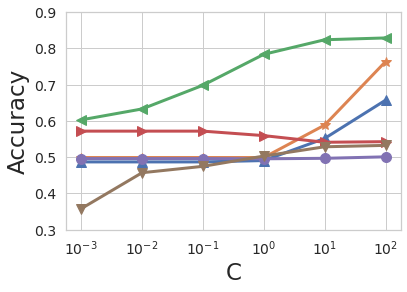

In [152]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["C"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["accuracy"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('C', fontsize=LABELSIZE)
plt.ylabel('Accuracy', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0.3, 0.9)
plt.xscale("log")
plt.legend('', frameon=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/logistic_regression/accuracy.png", bbox_inches = 'tight', dpi=300)
plt.show()

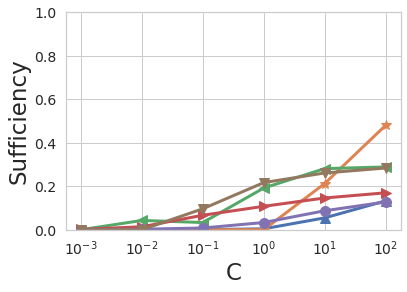

In [153]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["C"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["sufficiency"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('C', fontsize=LABELSIZE)
plt.ylabel('Sufficiency', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0, 1)
plt.xscale("log")
plt.legend('', frameon=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/logistic_regression/sufficiency.png", bbox_inches = 'tight', dpi=300)
plt.show()

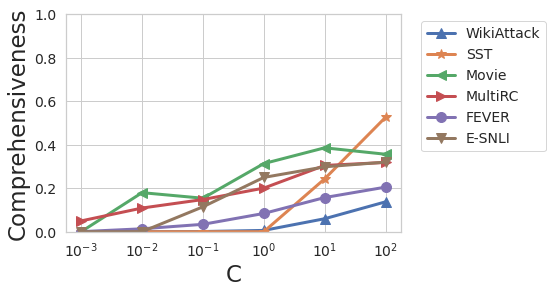

In [154]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["C"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["comprehensiveness"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('C', fontsize=LABELSIZE)
plt.ylabel('Comprehensiveness', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0, 1)
plt.xscale("log")
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/logistic_regression/comprehensiveness.png", bbox_inches = 'tight', dpi=300)
plt.show()

## Fig 12

In [155]:
output_dir = os.path.join(OUTPUT_DIR, "random_forest")
datasets = ["wikiattack", "sst", "movies", "multirc", "fever", "esnli"]
plot_data = {"dataset": [], "accuracy": [], "sufficiency": [], "comprehensiveness": [], "No. of estimators": []}
ne_list = [4, 16, 64, 256, 512]
for dataset in datasets:
    for ne in ne_list:
#         C=10_d=fever
        load_dir = "d="+dataset+"_ne="+str(ne)
        ne = load_dir.split("=")[2]
        feature_df = pd.read_csv(os.path.join(output_dir, os.path.join(load_dir, "feature.csv")))
        display(feature_df)

        y_hat = feature_df["predicted_classes"].to_numpy()
        y = feature_df["true_classes"].to_numpy()
        prob_y_hat = feature_df["prob_y_hat"].to_numpy()
        prob_y_hat_alpha = feature_df["prob_y_hat_alpha"].to_numpy()
        prob_y_hat_alpha_comp = feature_df["prob_y_hat_alpha_comp"].to_numpy()
        null_difference = feature_df["null_diff"].to_numpy()

        normalized_sufficiency = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                             prob_y_hat_alpha=prob_y_hat_alpha,
                                             normalization=True, null_difference=null_difference)

        normalized_comprehensiveness = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                                    prob_y_hat_alpha=prob_y_hat_alpha_comp,
                                                    fidelity_type="comprehensiveness",
                                                    normalization=True, null_difference=null_difference)

        plot_data["dataset"].append(lowercase_to_abs[dataset])
        plot_data["No. of estimators"].append(ne)
        plot_data["accuracy"].append(mt.accuracy_score(y, y_hat))

        plot_data["sufficiency"].append(normalized_sufficiency)
        plot_data["comprehensiveness"].append(normalized_comprehensiveness)
plot_data_df = pd.DataFrame(plot_data)

,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,1.00,1.00,1.00,0.00,0,0
1,1,1.00,1.00,1.00,0.00,0,0
2,2,1.00,1.00,1.00,0.00,0,0
3,3,0.50,0.50,1.00,0.00,0,0
4,4,1.00,1.00,1.00,0.00,0,0
...,...,...,...,...,...,...,...
535,535,1.00,1.00,1.00,0.00,0,0
536,536,0.75,0.75,0.50,0.75,1,1
537,537,1.00,1.00,1.00,0.00,1,0
538,538,0.75,1.00,0.75,0.00,0,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,1.000,1.000,1.000,0.00,0,0
1,1,1.000,1.000,1.000,0.00,0,0
2,2,0.938,1.000,0.938,0.00,0,0
3,3,0.812,0.812,1.000,0.00,0,0
4,4,1.000,1.000,1.000,0.00,0,0
...,...,...,...,...,...,...,...
535,535,0.875,1.000,0.875,0.00,0,0
536,536,0.750,0.812,0.500,0.75,1,1
537,537,0.812,0.938,0.875,0.00,1,0
538,538,0.812,1.000,0.812,0.00,0,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,1.000,1.000,1.000,0.000,0,0
1,1,1.000,1.000,1.000,0.000,0,0
2,2,0.938,1.000,0.938,0.000,0,0
3,3,0.688,0.688,1.000,0.000,0,0
4,4,0.891,1.000,0.891,0.000,0,0
...,...,...,...,...,...,...,...
535,535,0.844,1.000,0.844,0.000,0,0
536,536,0.609,0.828,0.297,0.609,1,1
537,537,0.922,0.922,0.922,0.000,1,0
538,538,0.703,1.000,0.703,0.000,0,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.957,1.000,0.957,0.000,0,0
1,1,0.996,1.000,0.996,0.000,0,0
2,2,0.961,1.000,0.961,0.000,0,0
3,3,0.660,0.660,1.000,0.000,0,0
4,4,0.820,1.000,0.820,0.000,0,0
...,...,...,...,...,...,...,...
535,535,0.918,1.000,0.918,0.000,0,0
536,536,0.719,0.770,0.371,0.719,1,1
537,537,0.922,0.938,0.949,0.000,1,0
538,538,0.820,1.000,0.820,0.000,0,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.975,1.000,0.975,0.000,0,0
1,1,0.984,1.000,0.984,0.000,0,0
2,2,0.965,1.000,0.965,0.000,0,0
3,3,0.689,0.689,1.000,0.000,0,0
4,4,0.859,1.000,0.859,0.000,0,0
...,...,...,...,...,...,...,...
535,535,0.902,1.000,0.902,0.000,0,0
536,536,0.693,0.812,0.404,0.693,1,1
537,537,0.945,0.924,0.924,0.000,1,0
538,538,0.762,1.000,0.762,0.000,0,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.75,1.00,0.50,0.00,1,1
1,1,0.50,0.50,0.50,0.25,1,0
2,2,1.00,1.00,0.75,0.25,1,1
3,3,0.75,1.00,0.75,0.50,1,0
4,4,0.50,0.25,0.25,0.25,1,0
...,...,...,...,...,...,...,...
1816,1816,0.75,0.75,0.25,0.50,1,0
1817,1817,1.00,1.00,0.75,0.25,1,1
1818,1818,0.75,0.50,0.75,0.00,1,1
1819,1819,0.50,0.50,0.25,0.25,1,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.750,0.875,0.312,0.000,1,1
1,1,0.625,0.688,0.438,0.438,1,0
2,2,0.812,0.812,0.812,0.000,1,1
3,3,0.562,0.875,0.625,0.375,1,0
4,4,0.812,0.375,0.625,0.625,1,0
...,...,...,...,...,...,...,...
1816,1816,0.500,0.438,0.188,0.312,1,0
1817,1817,1.000,0.938,0.750,0.188,1,1
1818,1818,0.562,0.500,0.812,0.000,1,1
1819,1819,0.562,0.688,0.688,0.000,1,1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.516,0.828,0.422,0.000,1,1
1,1,0.547,0.625,0.609,0.094,1,0
2,2,0.875,0.859,0.547,0.328,1,1
3,3,0.625,0.719,0.453,0.172,1,0
4,4,0.672,0.406,0.500,0.219,1,0
...,...,...,...,...,...,...,...
1816,1816,0.578,0.531,0.578,0.031,1,1
1817,1817,0.875,0.719,0.641,0.328,1,1
1818,1818,0.656,0.516,0.609,0.109,1,1
1819,1819,0.594,0.453,0.500,0.141,1,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.586,0.867,0.391,0.000,1,1
1,1,0.602,0.664,0.551,0.223,1,0
2,2,0.863,0.852,0.621,0.242,1,1
3,3,0.590,0.664,0.461,0.211,1,0
4,4,0.551,0.414,0.520,0.172,1,0
...,...,...,...,...,...,...,...
1816,1816,0.566,0.547,0.637,0.000,1,1
1817,1817,0.910,0.781,0.676,0.289,1,1
1818,1818,0.730,0.633,0.645,0.109,1,1
1819,1819,0.625,0.488,0.422,0.246,1,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.629,0.855,0.400,0.000,1,1
1,1,0.623,0.646,0.545,0.277,1,0
2,2,0.814,0.799,0.654,0.160,1,1
3,3,0.584,0.629,0.432,0.238,1,0
4,4,0.613,0.479,0.562,0.268,1,0
...,...,...,...,...,...,...,...
1816,1816,0.605,0.562,0.688,0.000,1,1
1817,1817,0.896,0.797,0.719,0.242,1,1
1818,1818,0.734,0.619,0.689,0.080,1,1
1819,1819,0.613,0.480,0.430,0.268,1,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.50,0.75,0.00,0.00,0,0
1,1,0.50,1.00,0.75,0.00,0,0
2,2,0.75,0.25,0.25,0.50,0,1
3,3,0.75,0.25,0.50,0.50,0,1
4,4,1.00,1.00,0.75,0.25,0,0
...,...,...,...,...,...,...,...
194,194,1.00,0.25,0.75,0.25,1,0
195,195,0.50,0.75,0.50,0.00,1,0
196,196,1.00,0.75,0.75,0.25,1,0
197,197,0.75,0.25,0.75,0.00,1,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.750,0.438,0.625,0.000,0,0
1,1,0.562,0.125,0.562,0.438,0,1
2,2,0.750,0.750,0.562,0.000,0,0
3,3,0.500,0.562,0.688,0.000,0,0
4,4,0.688,0.812,0.688,0.000,0,0
...,...,...,...,...,...,...,...
194,194,0.625,0.688,0.562,0.500,1,1
195,195,0.688,0.188,0.500,0.562,1,1
196,196,0.500,0.812,0.500,0.000,1,0
197,197,0.562,0.500,0.625,0.438,1,1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.609,0.688,0.578,0.000,0,0
1,1,0.516,0.328,0.391,0.219,0,1
2,2,0.641,0.516,0.531,0.000,0,0
3,3,0.609,0.344,0.328,0.312,0,1
4,4,0.703,0.734,0.656,0.000,0,0
...,...,...,...,...,...,...,...
194,194,0.547,0.750,0.531,0.250,1,1
195,195,0.781,0.250,0.625,0.484,1,1
196,196,0.797,0.391,0.734,0.500,1,1
197,197,0.578,0.469,0.750,0.281,1,1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.566,0.773,0.379,0.000,0,0
1,1,0.562,0.262,0.391,0.355,0,1
2,2,0.707,0.621,0.598,0.000,0,0
3,3,0.547,0.348,0.387,0.340,0,1
4,4,0.742,0.801,0.688,0.000,0,0
...,...,...,...,...,...,...,...
194,194,0.539,0.613,0.605,0.332,1,1
195,195,0.652,0.227,0.574,0.445,1,1
196,196,0.699,0.336,0.668,0.492,1,1
197,197,0.582,0.398,0.641,0.375,1,1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.615,0.742,0.402,0.000,0,0
1,1,0.502,0.732,0.572,0.000,0,0
2,2,0.613,0.619,0.625,0.000,0,0
3,3,0.572,0.328,0.383,0.330,0,1
4,4,0.729,0.764,0.717,0.000,0,0
...,...,...,...,...,...,...,...
194,194,0.564,0.336,0.414,0.000,1,0
195,195,0.693,0.299,0.580,0.451,1,1
196,196,0.738,0.352,0.686,0.496,1,1
197,197,0.572,0.383,0.607,0.330,1,1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.75,0.5,1.0,0.25,1,1
1,1,0.75,0.5,1.0,0.25,1,1
2,2,0.75,0.5,1.0,0.25,1,1
3,3,0.75,0.5,1.0,0.25,0,1
4,4,0.75,0.5,1.0,0.25,0,1
...,...,...,...,...,...,...,...
4843,4843,0.50,0.5,0.0,0.00,0,0
4844,4844,0.50,0.5,0.0,0.00,0,0
4845,4845,0.50,0.5,0.0,0.00,1,0
4846,4846,0.50,0.5,0.0,0.00,1,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.688,0.188,0.438,0.438,1,1
1,1,0.625,0.188,0.438,0.375,1,1
2,2,0.562,0.250,0.438,0.312,1,1
3,3,0.562,0.250,0.438,0.312,0,1
4,4,0.562,0.250,0.438,0.312,0,1
...,...,...,...,...,...,...,...
4843,4843,0.625,0.875,0.562,0.000,0,0
4844,4844,0.625,0.875,0.562,0.000,0,0
4845,4845,0.625,0.938,0.562,0.000,1,0
4846,4846,0.625,0.938,0.562,0.000,1,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.582,0.297,0.516,0.379,1,1
1,1,0.590,0.219,0.516,0.387,1,1
2,2,0.590,0.234,0.516,0.387,1,1
3,3,0.582,0.234,0.516,0.379,0,1
4,4,0.582,0.234,0.516,0.379,0,1
...,...,...,...,...,...,...,...
4843,4843,0.525,0.266,0.359,0.322,0,1
4844,4844,0.506,0.766,0.641,0.000,0,0
4845,4845,0.525,0.266,0.359,0.322,1,1
4846,4846,0.525,0.266,0.359,0.322,1,1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.571,0.320,0.557,0.325,1,1
1,1,0.563,0.270,0.557,0.317,1,1
2,2,0.569,0.270,0.557,0.323,1,1
3,3,0.553,0.270,0.557,0.307,0,1
4,4,0.565,0.270,0.557,0.319,0,1
...,...,...,...,...,...,...,...
4843,4843,0.513,0.719,0.542,0.000,0,0
4844,4844,0.515,0.742,0.542,0.000,0,0
4845,4845,0.513,0.750,0.542,0.000,1,0
4846,4846,0.515,0.746,0.542,0.000,1,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.565,0.273,0.531,0.329,1,1
1,1,0.555,0.233,0.531,0.319,1,1
2,2,0.558,0.241,0.531,0.322,1,1
3,3,0.554,0.245,0.531,0.318,0,1
4,4,0.554,0.245,0.531,0.317,0,1
...,...,...,...,...,...,...,...
4843,4843,0.520,0.227,0.453,0.283,0,1
4844,4844,0.518,0.229,0.453,0.282,0,1
4845,4845,0.522,0.223,0.453,0.286,1,1
4846,4846,0.516,0.219,0.453,0.280,1,1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.809,1.00,0.559,0.059,1,1
1,1,0.500,0.25,0.000,0.250,0,0
2,2,0.750,0.25,0.750,0.500,0,0
3,3,0.750,1.00,0.750,0.000,1,1
4,4,0.595,1.00,1.000,0.000,1,1
...,...,...,...,...,...,...,...
6106,6106,0.750,0.50,0.500,0.000,0,1
6107,6107,0.571,1.00,0.821,0.000,1,1
6108,6108,0.750,0.75,0.750,0.000,0,1
6109,6109,0.750,0.75,0.250,0.500,0,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.517,0.875,0.416,0.000,1,1
1,1,0.688,0.750,0.688,0.000,0,1
2,2,0.625,0.875,0.500,0.000,0,1
3,3,0.750,0.812,0.938,0.000,1,1
4,4,0.550,0.312,0.462,0.425,1,0
...,...,...,...,...,...,...,...
6106,6106,0.875,0.688,0.750,0.000,0,1
6107,6107,0.586,0.062,0.649,0.461,1,0
6108,6108,0.938,0.812,0.875,0.062,0,1
6109,6109,0.812,0.812,0.125,0.688,0,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.501,0.094,0.469,0.361,1,0
1,1,0.719,0.797,0.604,0.000,0,1
2,2,0.690,0.922,0.741,0.000,0,1
3,3,0.781,0.818,0.891,0.000,1,1
4,4,0.681,0.791,0.711,0.000,1,1
...,...,...,...,...,...,...,...
6106,6106,0.609,0.594,0.719,0.000,0,1
6107,6107,0.568,0.172,0.455,0.427,1,0
6108,6108,0.681,0.828,0.760,0.000,0,1
6109,6109,0.672,0.672,0.141,0.531,0,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.541,0.887,0.548,0.000,1,1
1,1,0.759,0.797,0.693,0.000,0,1
2,2,0.687,0.879,0.716,0.000,0,1
3,3,0.803,0.801,0.835,0.010,1,1
4,4,0.650,0.729,0.683,0.000,1,1
...,...,...,...,...,...,...,...
6106,6106,0.688,0.578,0.808,0.000,0,1
6107,6107,0.644,0.859,0.581,0.000,1,1
6108,6108,0.799,0.854,0.781,0.006,0,1
6109,6109,0.691,0.691,0.207,0.484,0,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.539,0.871,0.552,0.000,1,1
1,1,0.711,0.794,0.705,0.000,0,1
2,2,0.654,0.906,0.649,0.000,0,1
3,3,0.787,0.821,0.862,0.000,1,1
4,4,0.638,0.755,0.692,0.000,1,1
...,...,...,...,...,...,...,...
6106,6106,0.674,0.598,0.782,0.000,0,1
6107,6107,0.553,0.869,0.545,0.000,1,1
6108,6108,0.783,0.861,0.737,0.000,0,1
6109,6109,0.692,0.692,0.186,0.505,0,0


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.50,0.00,0.25,0.50,0,0
1,1,0.50,0.50,1.00,0.00,1,1
2,2,0.75,0.75,1.00,0.00,2,1
3,3,0.75,0.25,0.00,0.75,0,2
4,4,0.75,1.00,0.25,0.00,1,1
...,...,...,...,...,...,...,...
9802,9802,1.00,0.00,0.25,1.00,1,2
9803,9803,0.50,0.00,0.25,0.50,2,0
9804,9804,0.75,0.25,0.50,0.75,0,2
9805,9805,0.75,1.00,0.50,0.00,1,1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.500,0.438,0.250,0.250,0,0
1,1,0.812,0.688,1.000,0.125,1,1
2,2,0.438,0.562,0.750,0.000,2,1
3,3,0.500,0.250,0.312,0.250,0,0
4,4,0.562,0.312,0.188,0.500,1,2
...,...,...,...,...,...,...,...
9802,9802,0.625,0.250,0.500,0.562,1,2
9803,9803,0.625,0.062,0.312,0.562,2,2
9804,9804,0.625,0.125,0.562,0.562,0,2
9805,9805,0.562,0.500,0.812,0.000,1,1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.766,0.281,0.234,0.547,0,0
1,1,0.797,0.656,0.771,0.172,1,1
2,2,0.422,0.594,0.625,0.000,2,1
3,3,0.469,0.125,0.375,0.312,0,2
4,4,0.453,0.797,0.672,0.000,1,1
...,...,...,...,...,...,...,...
9802,9802,0.766,0.016,0.453,0.609,1,2
9803,9803,0.703,0.172,0.344,0.547,2,2
9804,9804,0.484,0.078,0.641,0.328,0,2
9805,9805,0.562,0.594,0.812,0.000,1,1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.684,0.320,0.246,0.543,0,0
1,1,0.762,0.777,0.772,0.000,1,1
2,2,0.488,0.703,0.591,0.000,2,1
3,3,0.453,0.301,0.185,0.312,0,0
4,4,0.453,0.098,0.129,0.364,1,2
...,...,...,...,...,...,...,...
9802,9802,0.789,0.070,0.406,0.699,1,2
9803,9803,0.590,0.113,0.340,0.500,2,2
9804,9804,0.559,0.137,0.570,0.469,0,2
9805,9805,0.488,0.688,0.684,0.000,1,1


,Unnamed: 0,prob_y_hat,prob_y_hat_alpha,prob_y_hat_alpha_comp,null_diff,true_classes,predicted_classes
0,0,0.693,0.305,0.295,0.463,0,0
1,1,0.758,0.715,0.808,0.035,1,1
2,2,0.490,0.652,0.591,0.000,2,1
3,3,0.441,0.133,0.268,0.395,0,2
4,4,0.432,0.750,0.678,0.000,1,1
...,...,...,...,...,...,...,...
9802,9802,0.734,0.051,0.379,0.688,1,2
9803,9803,0.598,0.076,0.361,0.551,2,2
9804,9804,0.539,0.094,0.561,0.492,0,2
9805,9805,0.506,0.686,0.713,0.000,1,1


In [156]:
plot_data_df

,dataset,accuracy,sufficiency,comprehensiveness,No. of estimators
0,WikiAttack,0.633,0.129,0.112,4
1,WikiAttack,0.665,0.159,0.139,16
2,WikiAttack,0.670,0.167,0.147,64
3,WikiAttack,0.669,0.171,0.149,256
4,WikiAttack,0.672,0.178,0.154,512
5,SST,0.641,0.421,0.379,4
6,SST,0.689,0.399,0.261,16
7,SST,0.712,0.551,0.452,64
8,SST,0.720,0.477,0.372,256
9,SST,0.728,0.454,0.345,512


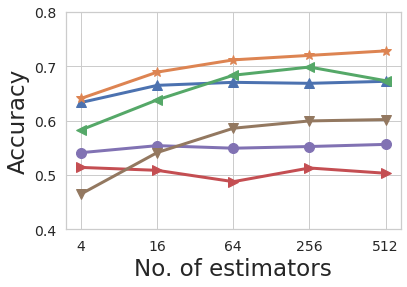

In [157]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["No. of estimators"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["accuracy"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('No. of estimators', fontsize=LABELSIZE)
plt.ylabel('Accuracy', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0.4, 0.8)
# plt.xscale("log")
plt.legend('', frameon=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/random_forest/accuracy.png", bbox_inches = 'tight', dpi=300)
plt.show()

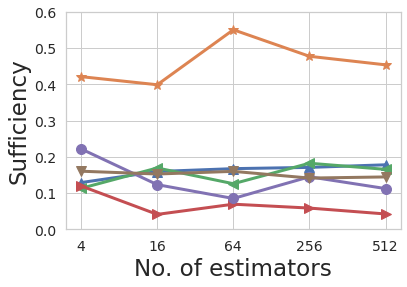

In [158]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["No. of estimators"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["sufficiency"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('No. of estimators', fontsize=LABELSIZE)
plt.ylabel('Sufficiency', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0.0, 0.6)
# plt.xscale("log")
plt.legend('', frameon=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/random_forest/sufficiency.png", bbox_inches = 'tight', dpi=300)
plt.show()

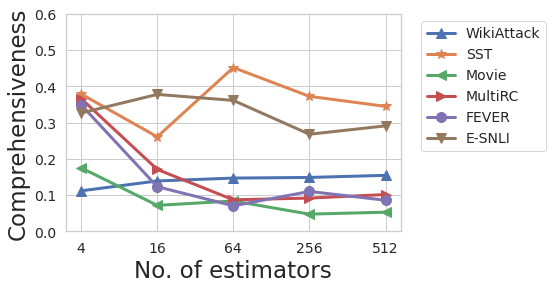

In [159]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["No. of estimators"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["comprehensiveness"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('No. of estimators', fontsize=LABELSIZE)
plt.ylabel('Comprehensiveness', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0, 0.6)
# plt.xscale("log")
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/random_forest/comprehensiveness.png", bbox_inches = 'tight', dpi=300)
plt.show()


## Figure 13

In [164]:
datasets = ["wikiattack", "sst", "movies", "multirc", "fever", "esnli"]
plot_data = {
    "dataset": [],
    "accuracy": [],
    "epoch": [],
    "sufficiency": [],
    "comprehensiveness": []
}


for dataset in datasets:
    epoch_wise_load_dir = "/data/sam/mita/output/lstm_retraining/lstm/d=" + str(dataset) + "_hs=200_lr=0.001_nte=10_pp=True"

    LOAD_DIR_LIST = [os.path.join(epoch_wise_load_dir, "epoch-0")]
    LOAD_DIR_LIST = LOAD_DIR_LIST + [os.path.join(epoch_wise_load_dir, name) for name in
                                     os.listdir(epoch_wise_load_dir) if "checkpoint-" in name]
    epoch = 0
    for epoch_feature_path in LOAD_DIR_LIST:
        feature_df = pd.read_csv(os.path.join(epoch_feature_path, "feature.csv"))
        y_hat = feature_df["predicted_classes"].to_numpy()
        y = feature_df["true_classes"].to_numpy()
        prob_y_hat = feature_df["prob_y_hat"].to_numpy()
        prob_y_hat_alpha = feature_df["prob_y_hat_alpha"].to_numpy()
        prob_y_hat_alpha_comp = feature_df["prob_y_hat_alpha_comp"].to_numpy()
        null_difference = feature_df["null_diff"].to_numpy()
        
        
        normalized_sufficiency = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                     prob_y_hat_alpha=prob_y_hat_alpha,
                                     null_difference=null_difference,
                                     normalization=True)

        normalized_comprehensiveness = fidelity_calculator.compute(prob_y_hat=prob_y_hat,
                                                    prob_y_hat_alpha=prob_y_hat_alpha_comp,
                                                    fidelity_type="comprehensiveness",
                                                    null_difference=null_difference,
                                                    normalization=True)

        plot_data["dataset"].append(lowercase_to_abs[dataset])
        plot_data["accuracy"].append(mt.accuracy_score(y, y_hat))
        plot_data["epoch"].append(epoch)
        plot_data["sufficiency"].append(normalized_sufficiency)
        plot_data["comprehensiveness"].append(normalized_comprehensiveness)
        epoch += 1
        
plot_data_df = pd.DataFrame(plot_data)

In [165]:
plot_data_df

,dataset,accuracy,epoch,sufficiency,comprehensiveness
0,WikiAttack,0.515,0,0.003,6.967e-04
1,WikiAttack,0.763,1,0.265,2.309e-01
2,WikiAttack,0.807,2,0.292,2.548e-01
3,WikiAttack,0.778,3,0.287,2.412e-01
4,WikiAttack,0.802,4,0.292,2.591e-01
...,...,...,...,...,...
61,E-SNLI,0.773,6,0.553,5.358e-01
62,E-SNLI,0.782,7,0.563,5.698e-01
63,E-SNLI,0.771,8,0.560,5.748e-01
64,E-SNLI,0.780,9,0.557,5.659e-01


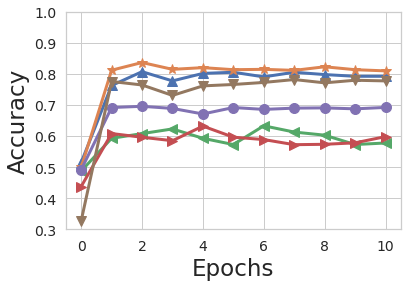

In [171]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["epoch"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["accuracy"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('Epochs', fontsize=LABELSIZE)
plt.ylabel('Accuracy', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0.3, 1)
plt.legend('', frameon=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/lstm/accuracy.png", bbox_inches = 'tight', dpi=300)
plt.show()

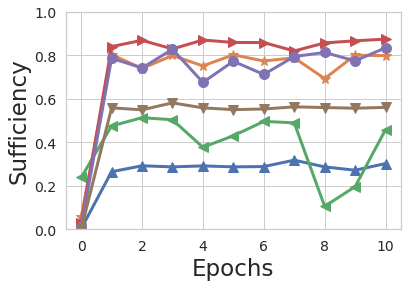

In [172]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["epoch"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["sufficiency"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('Epochs', fontsize=LABELSIZE)
plt.ylabel('Sufficiency', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0, 1)
plt.legend('', frameon=False)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/lstm/sufficiency.png", bbox_inches = 'tight', dpi=300)
plt.show()

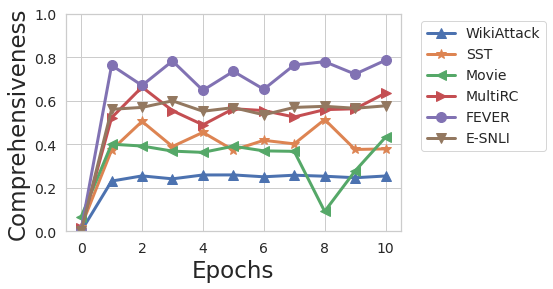

In [173]:
for idx in range(len(datasets)):
    plt.plot(plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["epoch"],
            plot_data_df[plot_data_df["dataset"] == lowercase_to_abs[datasets[idx]]]["comprehensiveness"],
            color=dataset_colors[dataset_names[idx]],
            marker=dataset_markers[dataset_names[idx]],
            label=acc_labels[dataset_names[idx]],
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE)

plt.legend(loc="upper left", bbox_to_anchor=(1.04,1), fontsize=LEGENDLABELSIZE)
plt.xlabel('Epochs', fontsize=LABELSIZE)
plt.ylabel('Comprehensiveness', fontsize=LABELSIZE)
plt.tick_params(axis="x", labelsize=TICKLABELSIZE)
plt.tick_params(axis="y", labelsize=TICKLABELSIZE)
plt.ylim(0, 1)
plt.savefig("/data/anirudh/output/evaluating_human_rationales/figs/lstm/comprehensiveness.png", bbox_inches = 'tight', dpi=300)
plt.show()